## Notebook for using the ML models trained on the dataset for Open-Source Reservoir (CMG simulations) 

Code in this notebook loads production models that were previously trained.

-------

*Written by: Dmitry Duplyakin (dmitry.duplyakin@nrel.gov) in collaboration with the National Renewable Energy Laboratories.*

*Full team: Dmitry Duplyakin, Koenraad F. Beckers, Drew L. Siler, Michael J. Martin, Henry E. Johnston*

### Necessary configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import uuid
from datetime import datetime
import glob
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
import math
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import math

loglevel = 'WARNING'
logging.basicConfig(level=os.environ.get("LOGLEVEL", loglevel))

# Import config file that is specific to CMG dataset
sys.path.append('../data/OpenSourceReservoir-CMG')
sys.path.append('../')

import config_cmg as config

#sys.path.append('..')
from reservoir.reservoir import Reservoir, ReservoirPredictionEnsemble

from polynomial import get_polynomial_func

%matplotlib inline
%config InlineBackend.figure_format='retina'

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

plt.style.use('ggplot')

### Loading data (from Xcel files to Pandas dataframes)

In [2]:
import copy

cases_list = []
cases_list_for_prediction = []

# This code assumes file names like: ../data/OpenSourceReservoir-CMG/OSR_<case #>.xlsx
data_dir = "../data/OpenSourceReservoir-CMG/"
filename_pattern = "OSR_*.xlsx"
cases = dict([(int(f.split("/")[-1].replace(".xlsx","").replace("OSR_", "")), f) for f 
         in glob.glob(data_dir + filename_pattern)])

for case in sorted(cases):

    file = cases[case]
    print("Processing: case %d, file %s" % (case, file))
    
    config_for_case = config
    
    # Override some config setting for this particular vis/analysis
    config_for_case.flow_unit = "kg/day"
    config_for_case.timeseries_file = file

    r = Reservoir(config_for_case, energy_calc=True)
    r_for_prediction =  Reservoir(config_for_case, energy_calc=False)
    cases_list.append(r)
    cases_list_for_prediction.append(r_for_prediction)
    
# It is expected to see several warnings ("Temperature outside valid area") - they refer to the issue 
# with energy calculation for historic data -- these warnings won't affect the rest of the analysis.

Processing: case 0, file ../data/OpenSourceReservoir-CMG/OSR_00000.xlsx


Processing: case 1, file ../data/OpenSourceReservoir-CMG/OSR_00001.xlsx
Processing: case 2, file ../data/OpenSourceReservoir-CMG/OSR_00002.xlsx
Processing: case 3, file ../data/OpenSourceReservoir-CMG/OSR_00003.xlsx
Processing: case 4, file ../data/OpenSourceReservoir-CMG/OSR_00004.xlsx
Processing: case 5, file ../data/OpenSourceReservoir-CMG/OSR_00005.xlsx
Processing: case 6, file ../data/OpenSourceReservoir-CMG/OSR_00006.xlsx
Processing: case 7, file ../data/OpenSourceReservoir-CMG/OSR_00007.xlsx
Processing: case 8, file ../data/OpenSourceReservoir-CMG/OSR_00008.xlsx
Processing: case 9, file ../data/OpenSourceReservoir-CMG/OSR_00009.xlsx
Processing: case 10, file ../data/OpenSourceReservoir-CMG/OSR_00010.xlsx
Processing: case 11, file ../data/OpenSourceReservoir-CMG/OSR_00011.xlsx
Processing: case 12, file ../data/OpenSourceReservoir-CMG/OSR_00012.xlsx
Processing: case 13, file ../data/OpenSourceReservoir-CMG/OSR_00013.xlsx
Processing: case 14, file ../data/OpenSourceReservoir-CMG/OS

### Combine different scenarios into an ensemble

In [3]:
ens = ReservoirPredictionEnsemble(config, cases_list)  
#ens.equalize_cumulative_values()
ens.scale()

# To see individual scaled timeseries, do the following:
# ens[0].scaled_timeseries

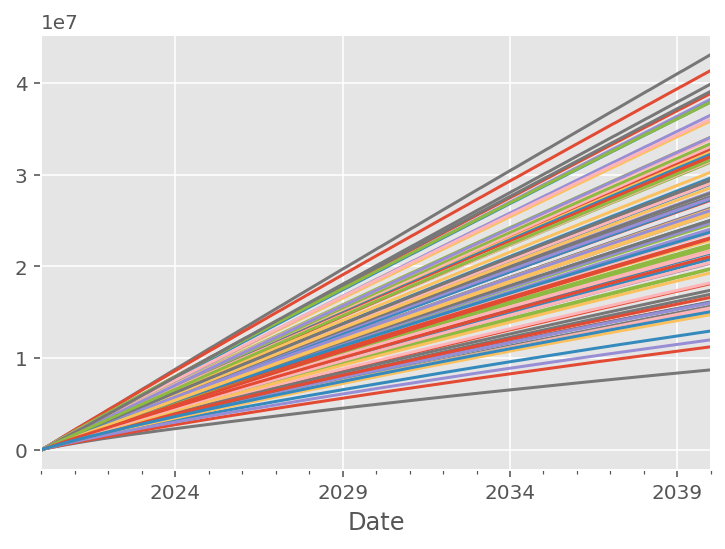

In [4]:
# Exclude case 0 becuase it covers longer period than simulated
for idx in range(1,101):
    ens[idx].energy_cumulative.plot()
    #print(idx, ens[idx].config.timeseries_file, ens[idx].energy_cumulative.max())

### Load results of cross-validation

In [5]:
all_idx = range(ens.count)
# This list comes from what is selected and printed in osr-3-train_production notebook
test_idx = [17, 36, 52, 55, 78, 82, 83, 85, 94, 95, 100]
train_idx = sorted(list(set(all_idx).difference(set(test_idx))))
print("Train:", train_idx)
print("Test:", test_idx)

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 84, 86, 87, 88, 89, 90, 91, 92, 93, 96, 97, 98, 99]
Test: [17, 36, 52, 55, 78, 82, 83, 85, 94, 95, 100]


### Load and evaluate saved models

In [6]:
# Load all saved models

model_dir = "../models/"
quantity_list = ["pp1", "pp2", "pp3", "pp4", "pp5", "pp6", "pt1", "pt2", "pt3", "pt4", "pt5", "pt6"]

trained_models_dict = {}
for quantity in quantity_list:
    model_path = os.path.join(model_dir, quantity) 
    print("Loading model for %s from file: %s" % (quantity, model_path))
    model = tf.keras.models.load_model(model_path, compile=True)
    trained_models_dict[quantity] = model

Loading model for pp1 from file: ../models/pp1
Loading model for pp2 from file: ../models/pp2
Loading model for pp3 from file: ../models/pp3
Loading model for pp4 from file: ../models/pp4
Loading model for pp5 from file: ../models/pp5
Loading model for pp6 from file: ../models/pp6
Loading model for pt1 from file: ../models/pt1
Loading model for pt2 from file: ../models/pt2
Loading model for pt3 from file: ../models/pt3
Loading model for pt4 from file: ../models/pt4
Loading model for pt5 from file: ../models/pt5
Loading model for pt6 from file: ../models/pt6


im1       im2      im3       im4       pm1       pm2       pm3  \
0     0.43091  0.639029  1.38781  0.681051  0.950629  0.460185  0.496246   
1     0.43091  0.479272  1.73477  0.510788  0.950629  0.690278  0.496246   
2     0.43091  0.319515  1.38781  0.681051   1.18829  0.230093  0.620308   
3    0.323182  0.798787  1.73477  0.340525   1.18829  0.345139  0.620308   
4    0.646365  0.479272  1.04086   1.02158   1.18829  0.575232  0.248123   
..        ...       ...      ...       ...       ...       ...       ...   
96   0.215455  0.639029  1.38781  0.340525  0.475314  0.575232  0.744369   
97   0.646365  0.319515  1.38781  0.510788  0.950629  0.690278  0.496246   
98   0.646365  0.639029  1.38781  0.340525  0.475314  0.230093  0.744369   
99   0.215455  0.958544  1.73477  0.340525  0.712971  0.345139  0.620308   
100  0.323182  0.798787  1.73477   1.02158  0.475314  0.690278  0.248123   

          pm4       pm5       pm6  
0    0.493607  0.970607  0.449299  
1    0.370205  0.485303  0.224649  
2    0.493607  0.485303   0.22465  
3    0.370205  0.970607  0.561624  
4    0.617009   1.21326  0.336975  
..        ...       ...       ...  
96   0.246803  0.970607    0.4493  
97   0.246804   1.21326  0.561624  
98   0.370205   1.21326   0.22465  
99   0.246803  0.970607  0.561624  
100  0.493607   1.21326   0.22465  

[101 rows x 10 columns]

Quantity: pp1


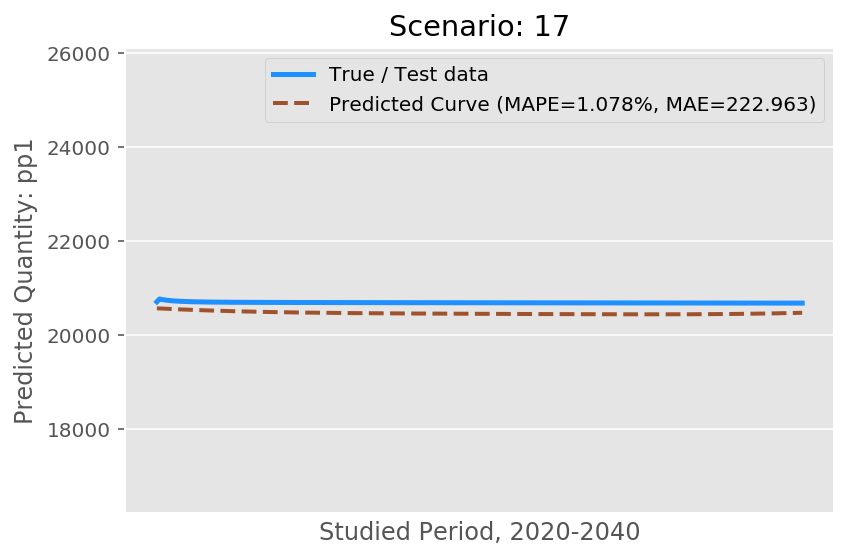

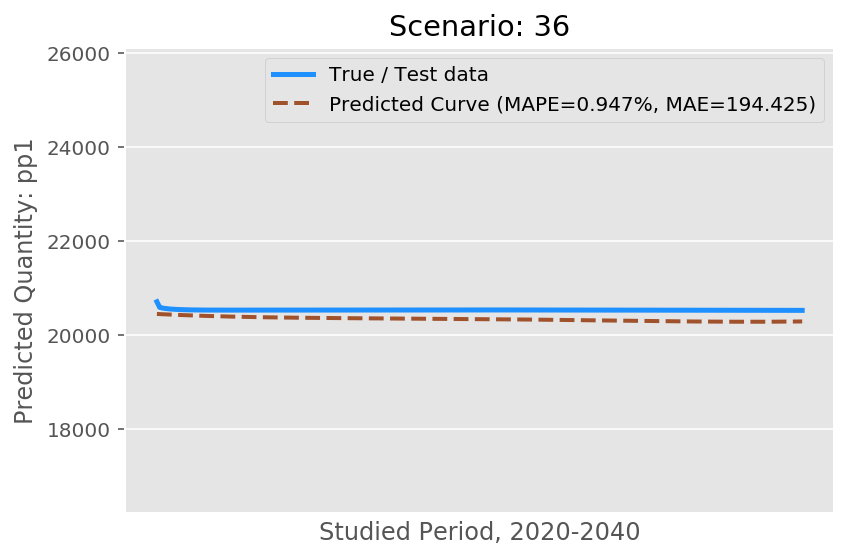

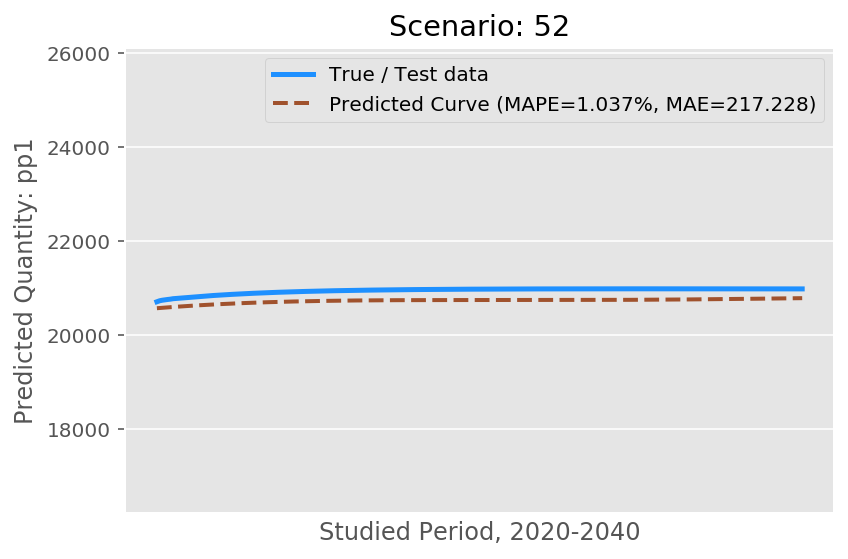

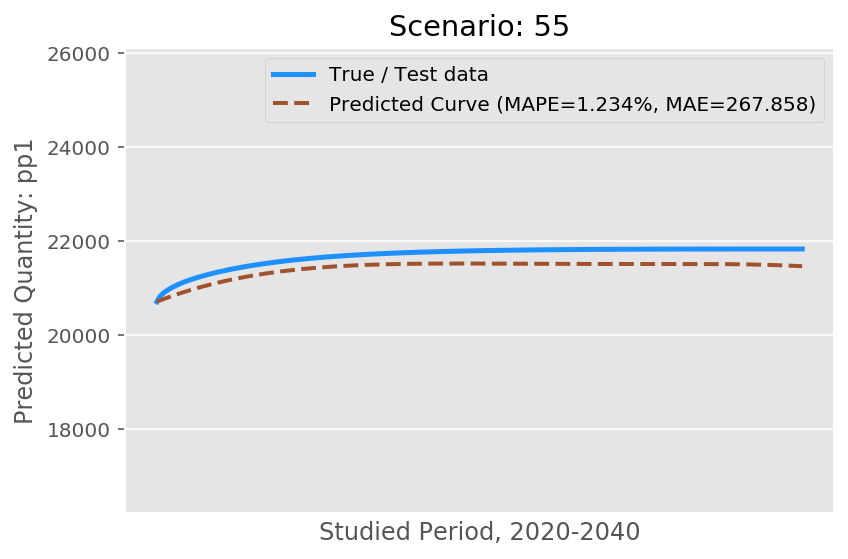

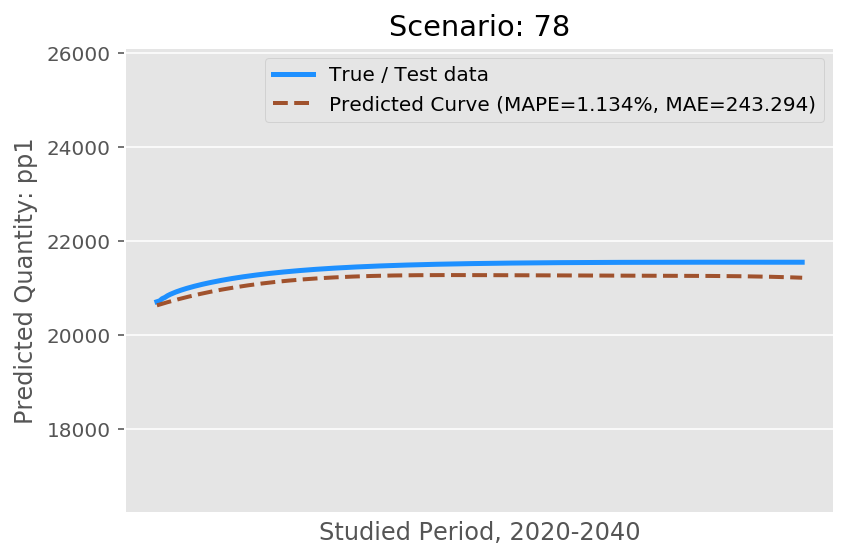

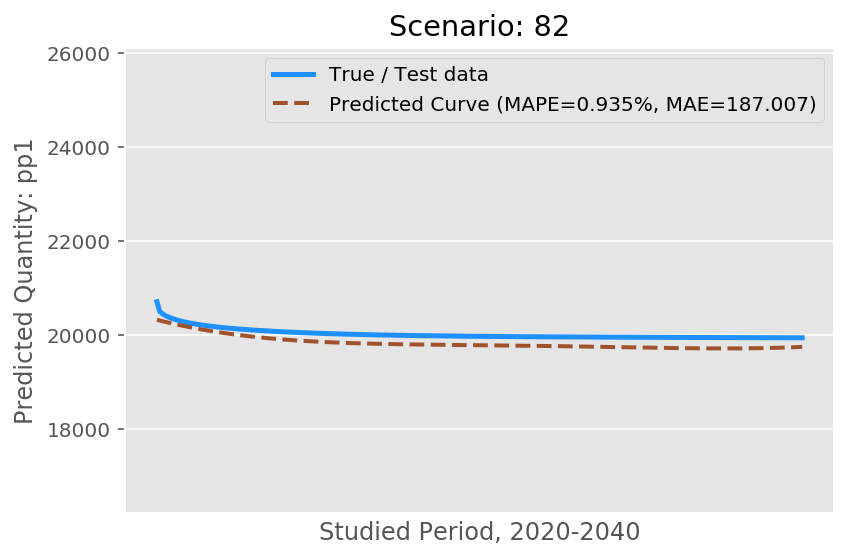

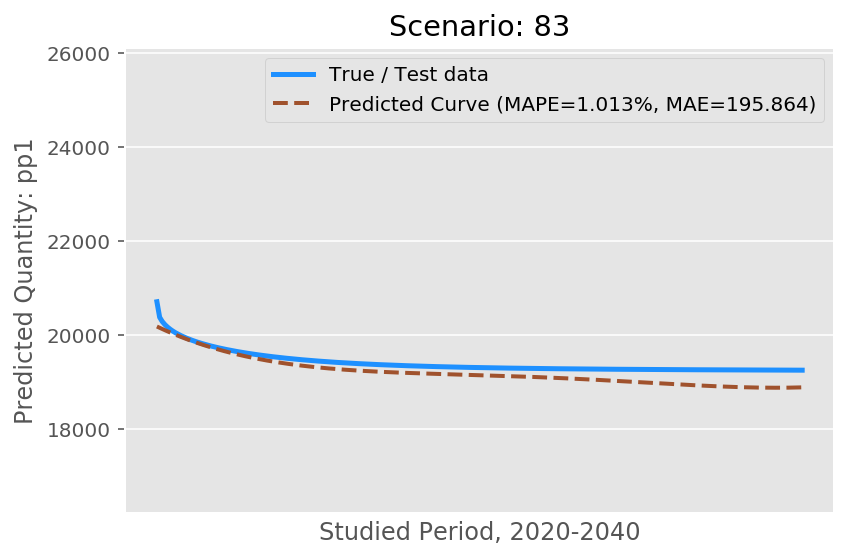

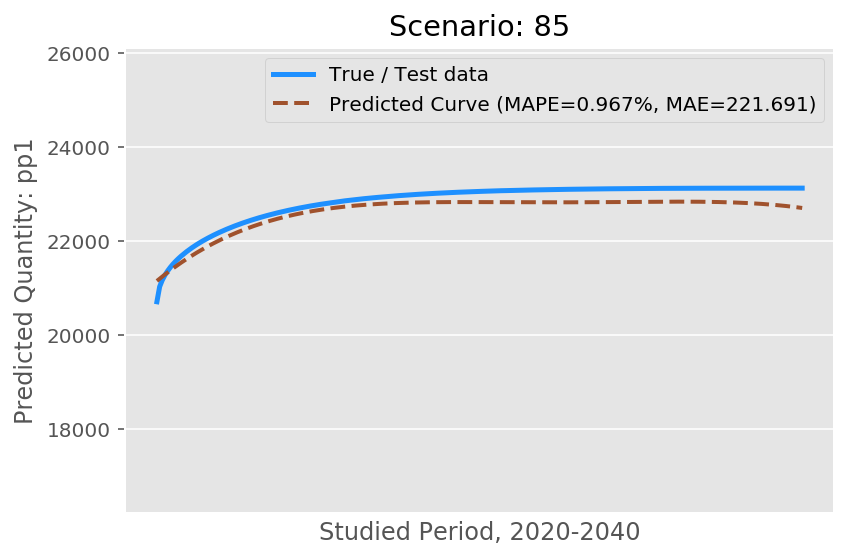

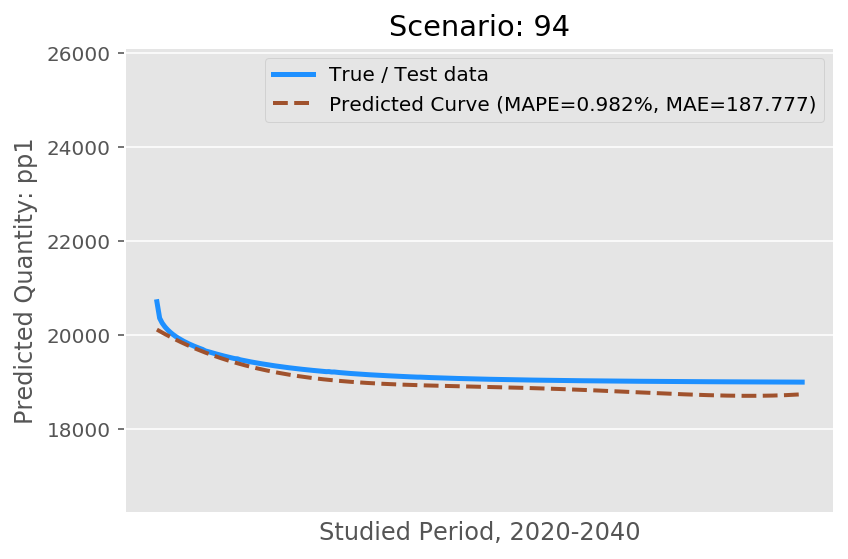

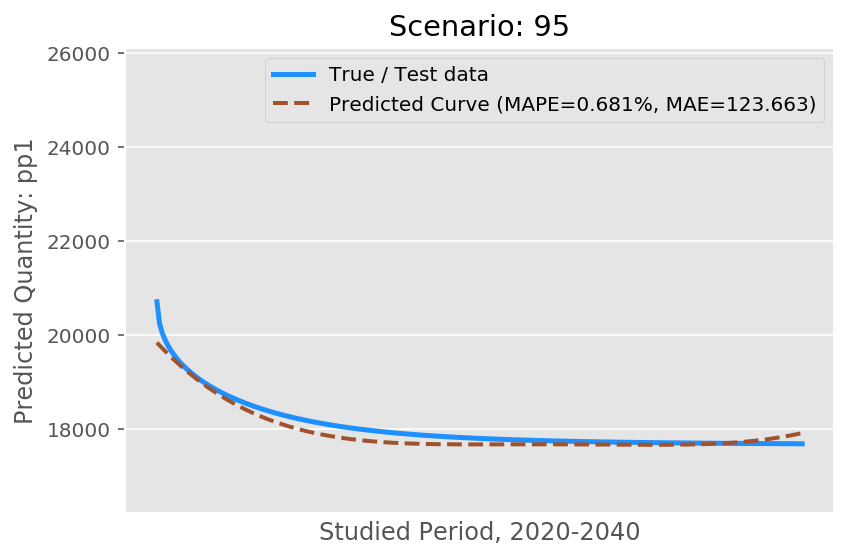

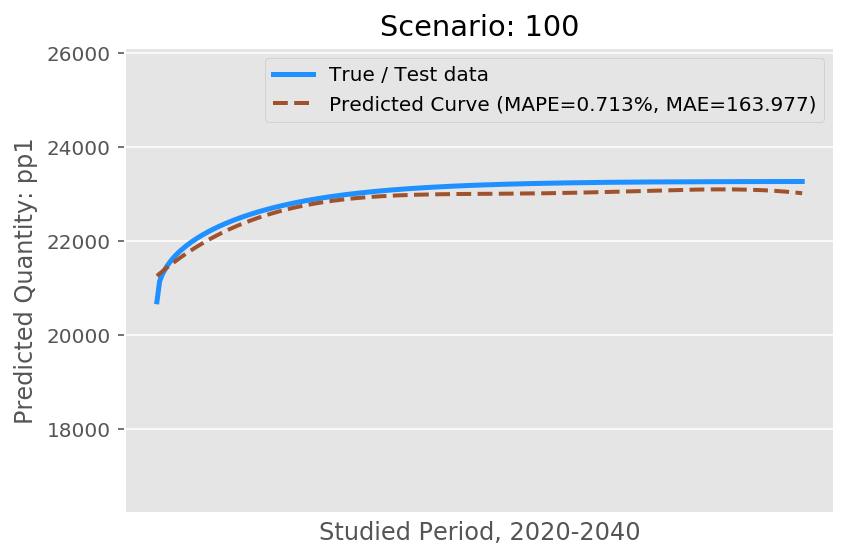

Quantity: pp2


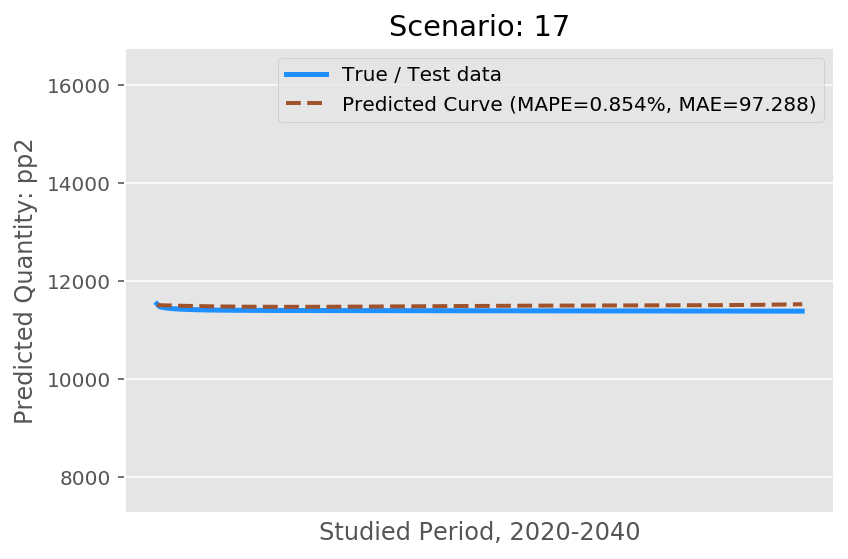

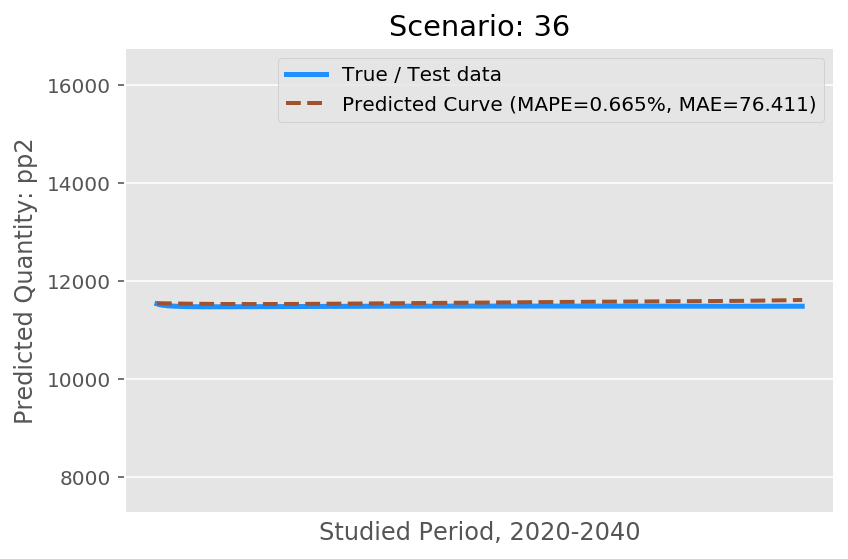

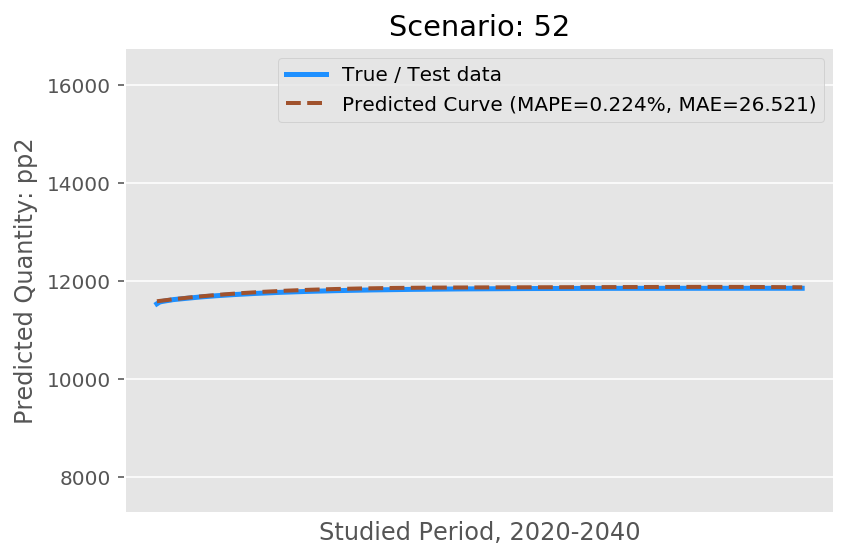

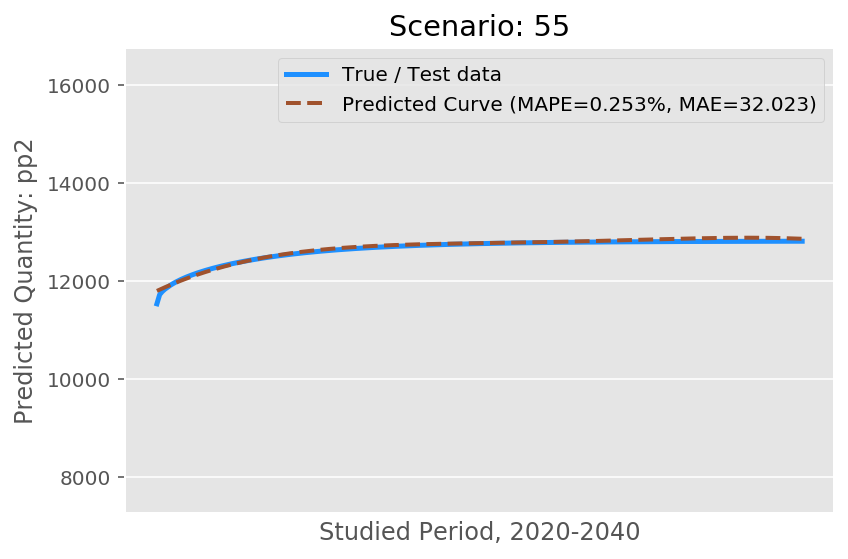

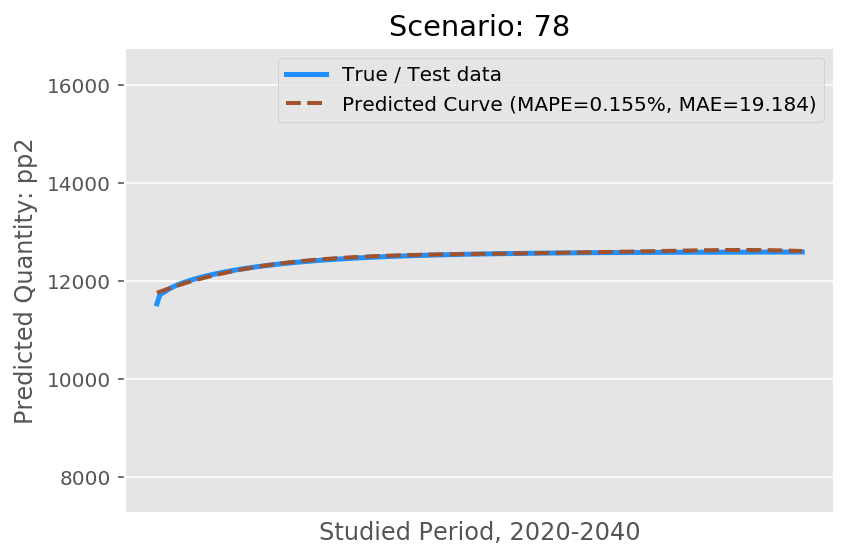

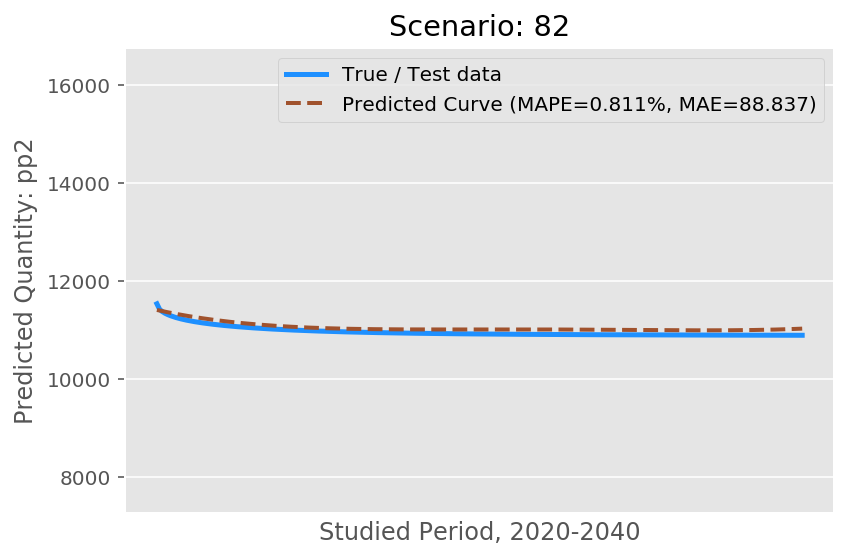

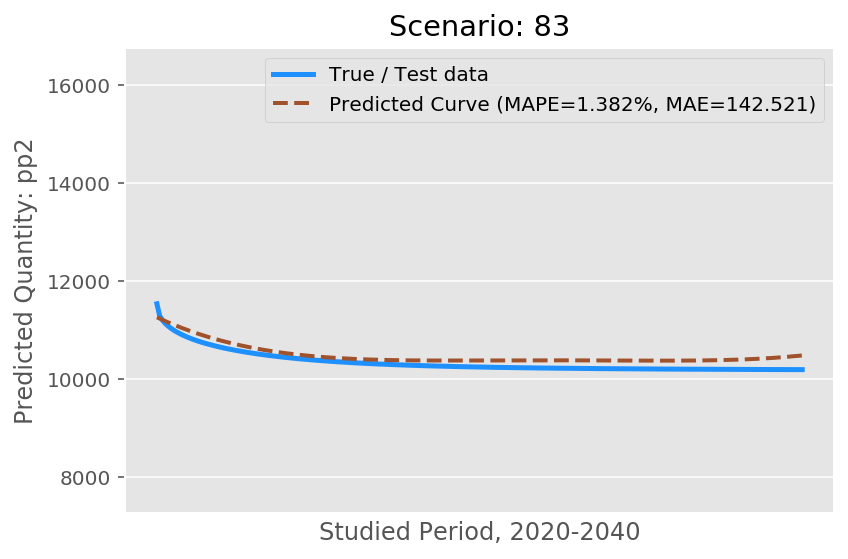

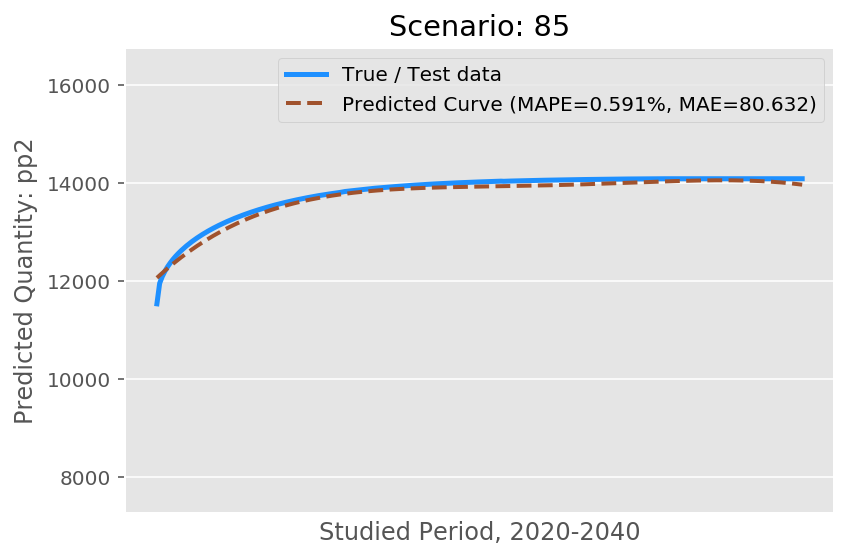

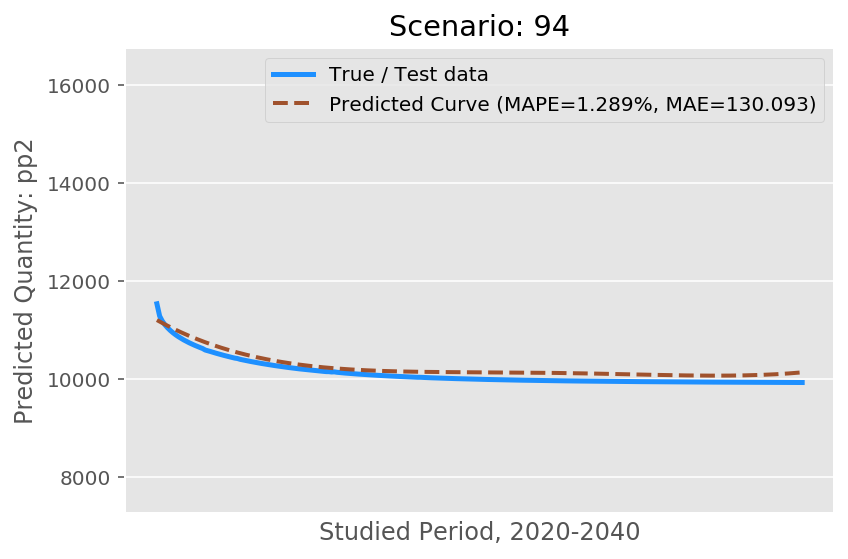

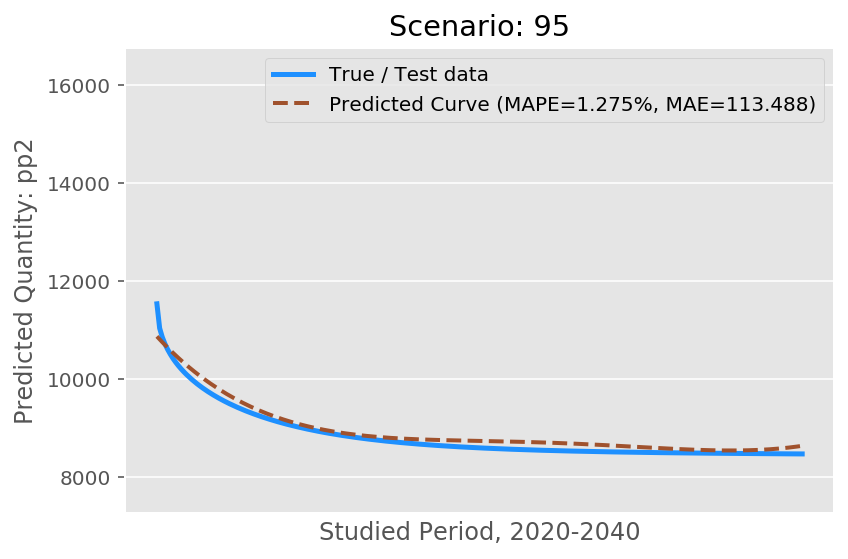

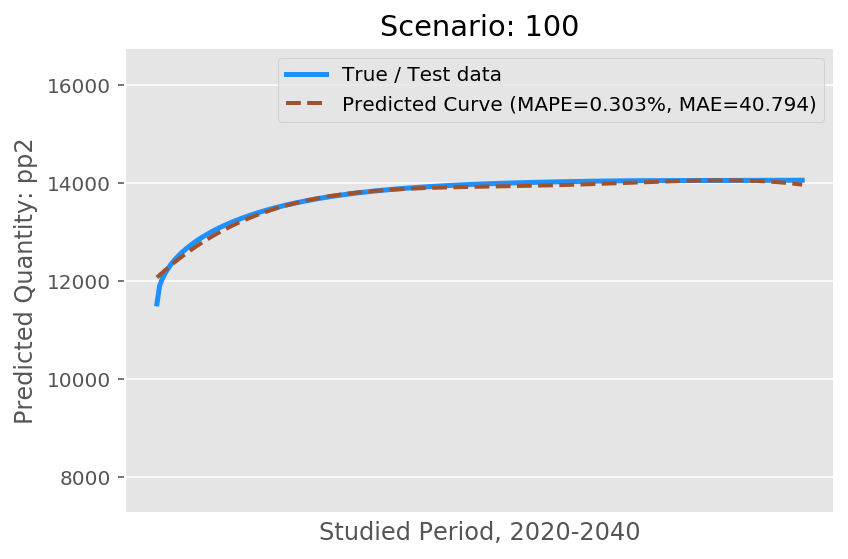

Quantity: pp3


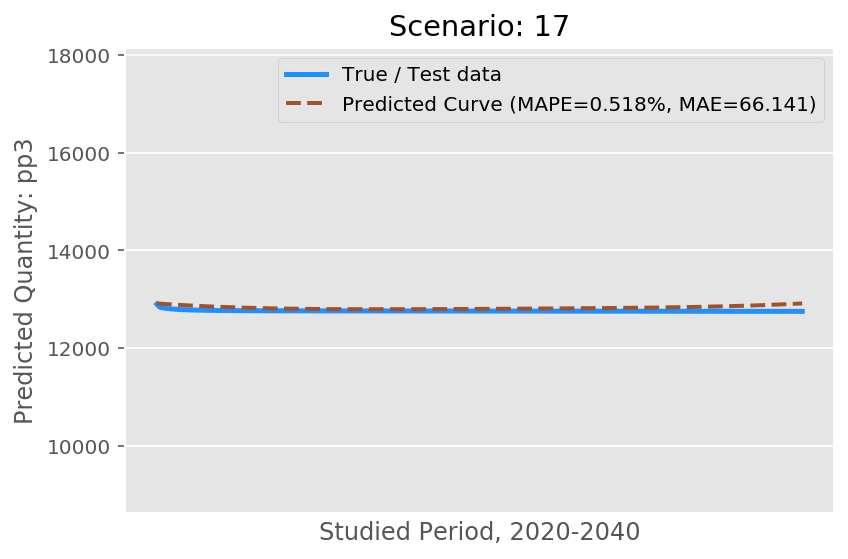

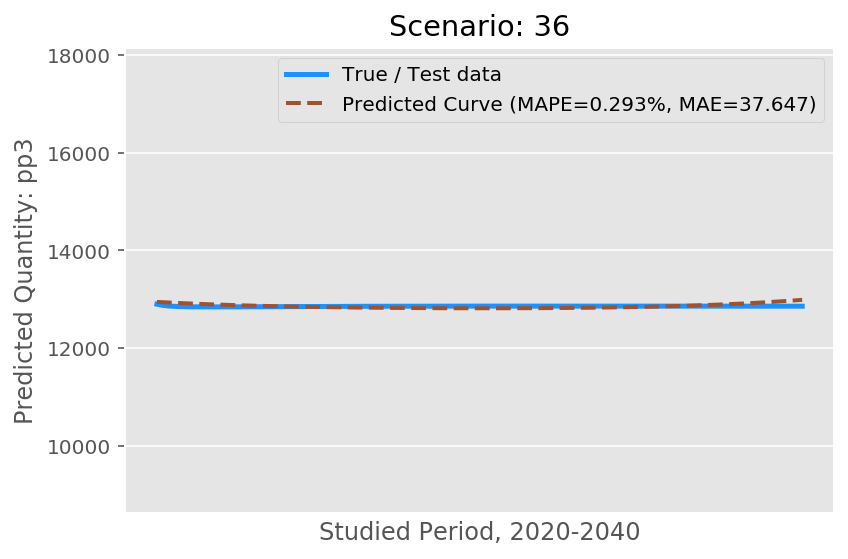

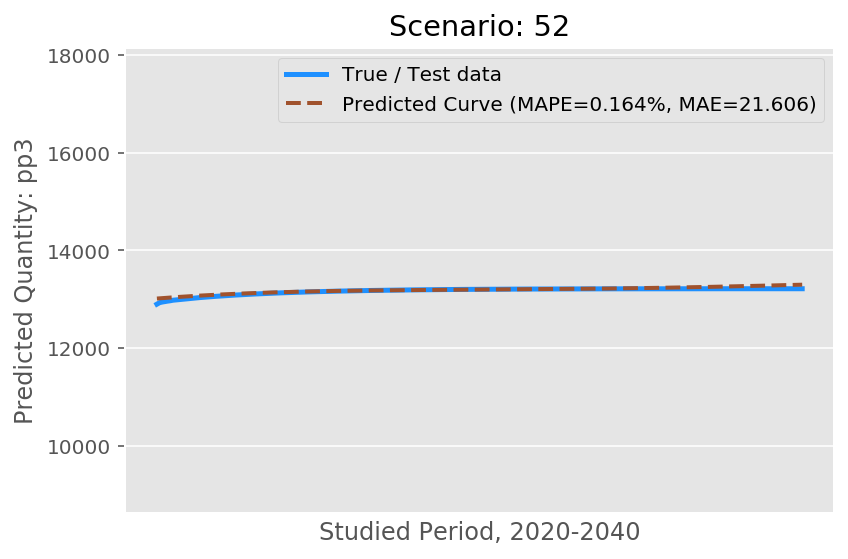

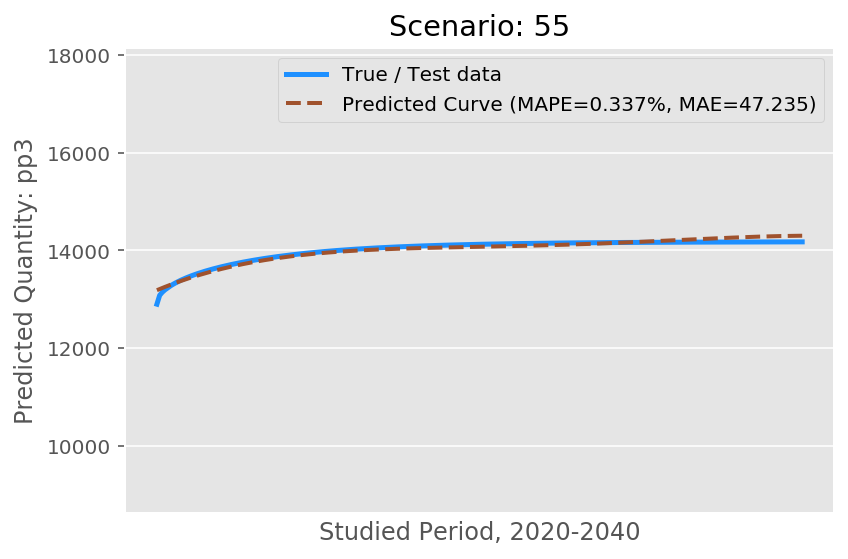

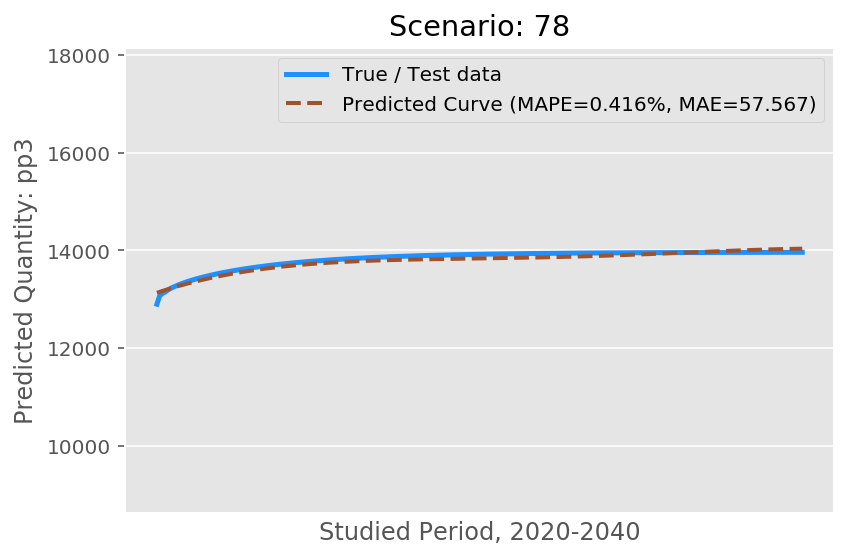

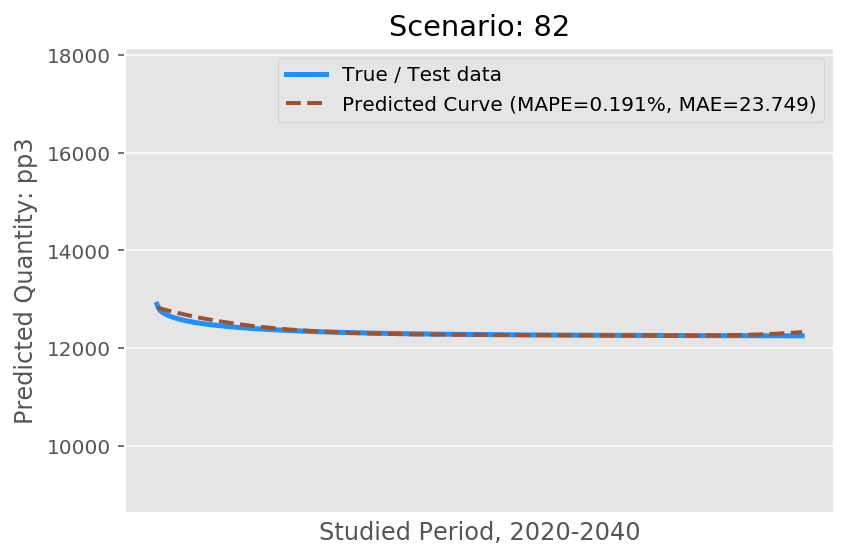

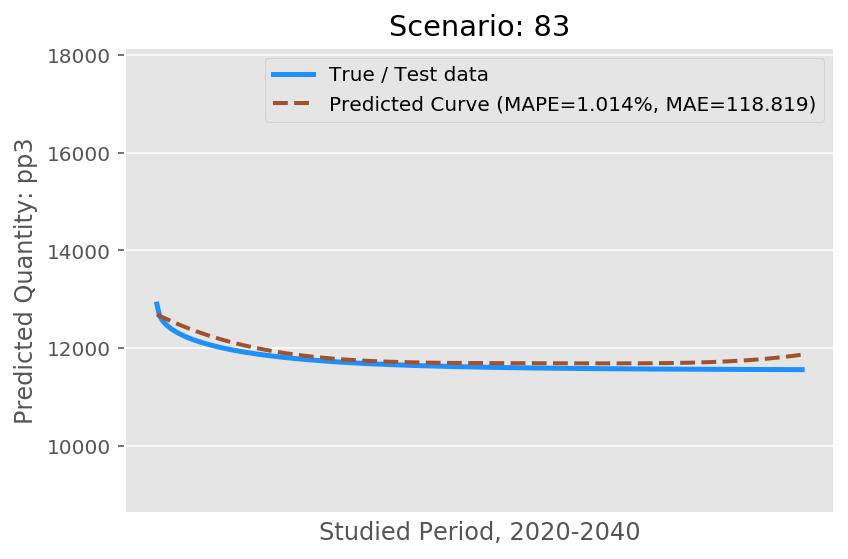

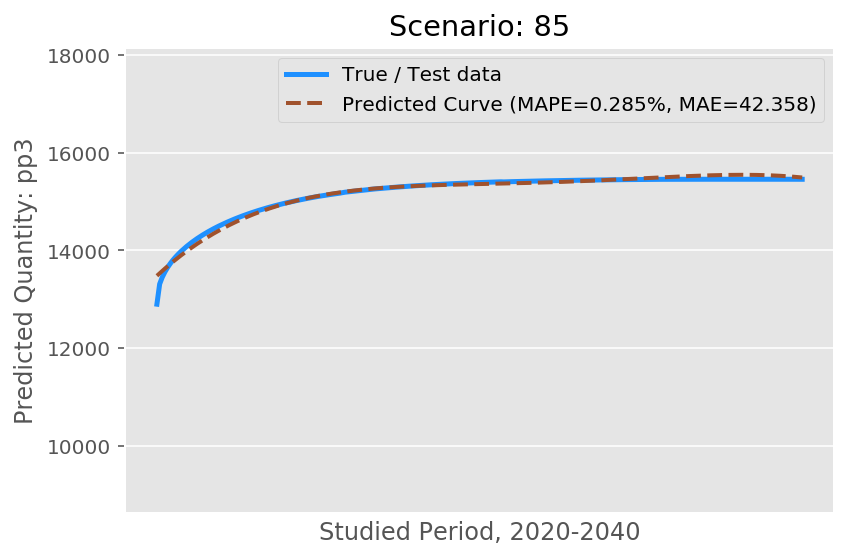

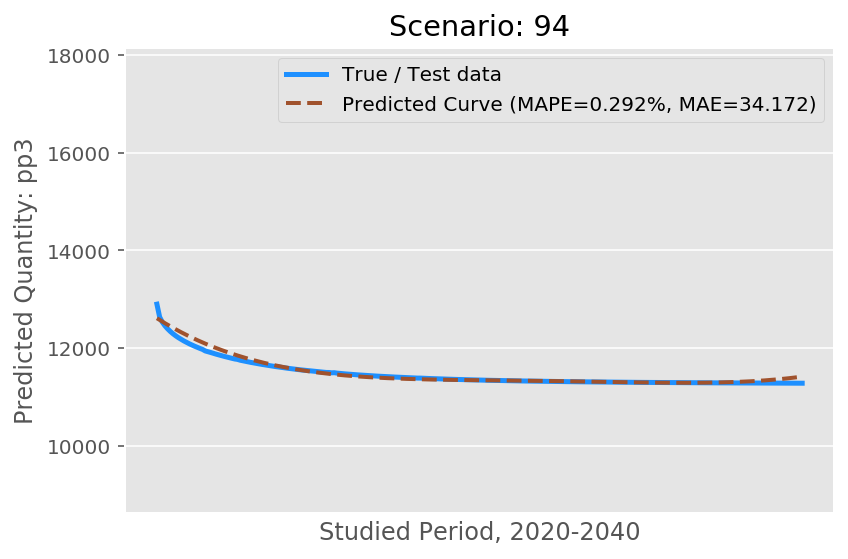

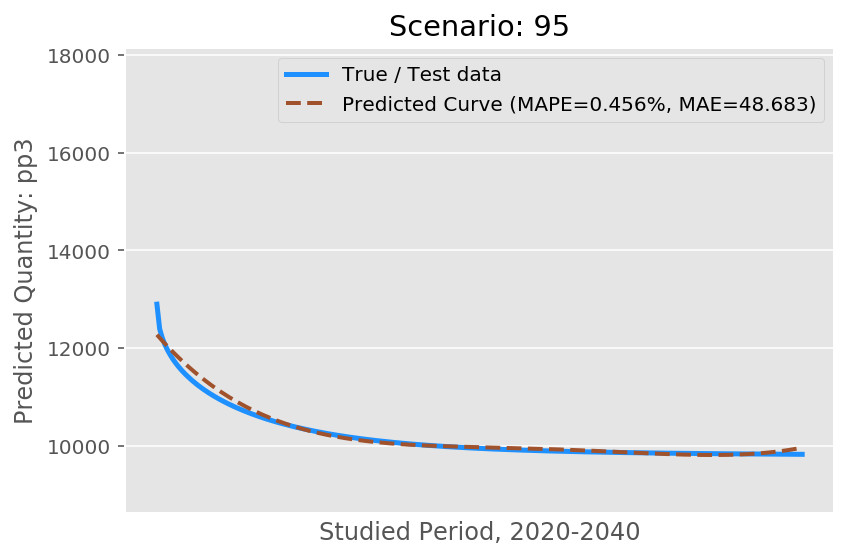

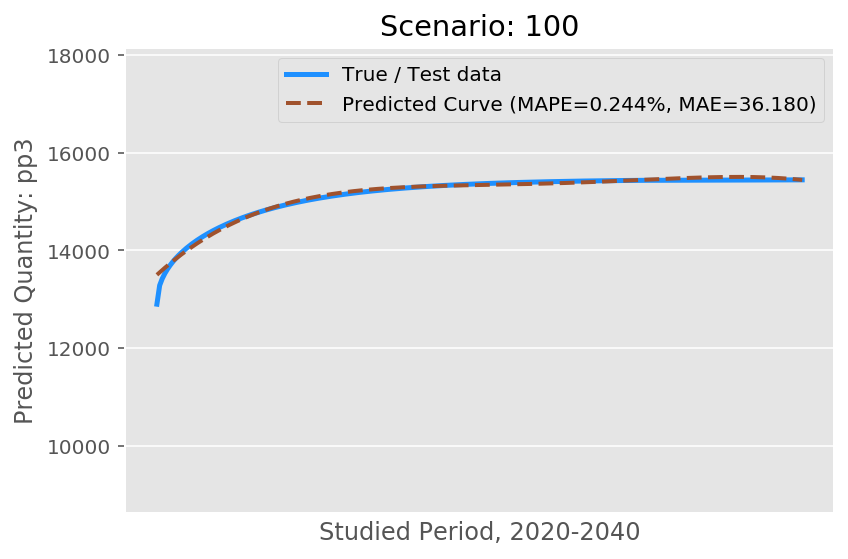

Quantity: pp4


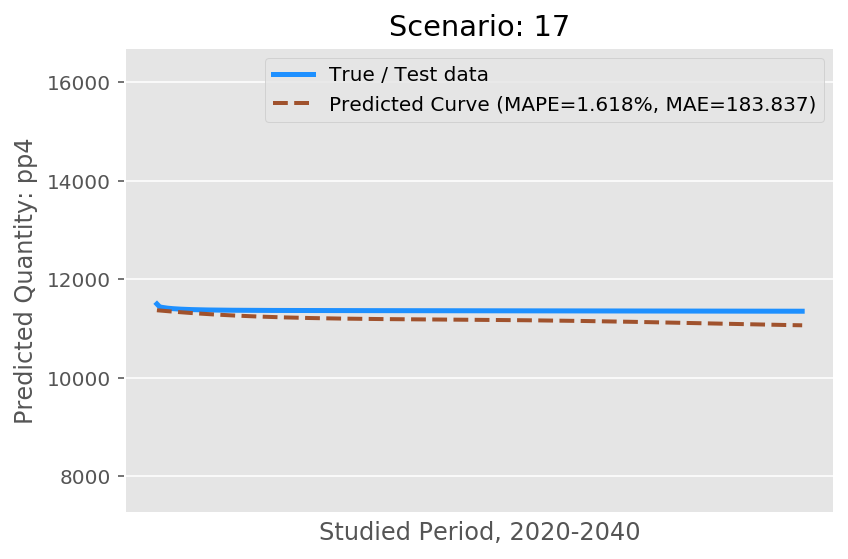

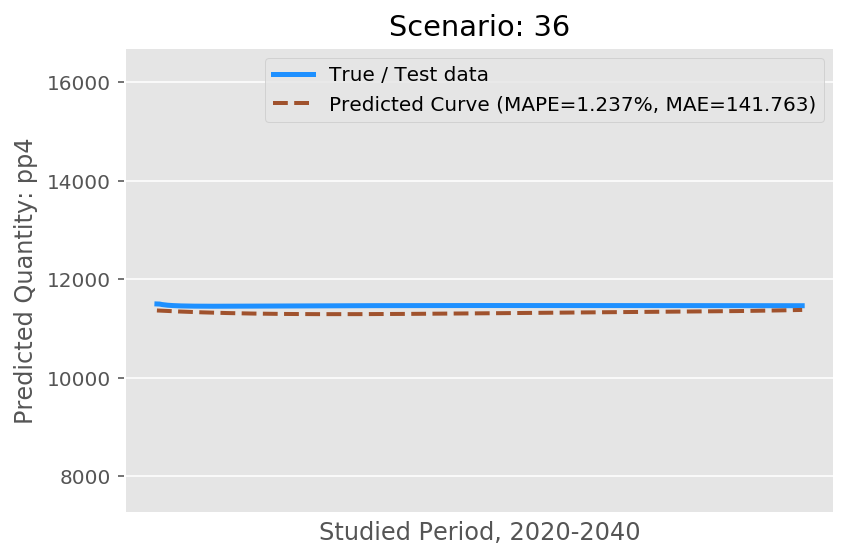

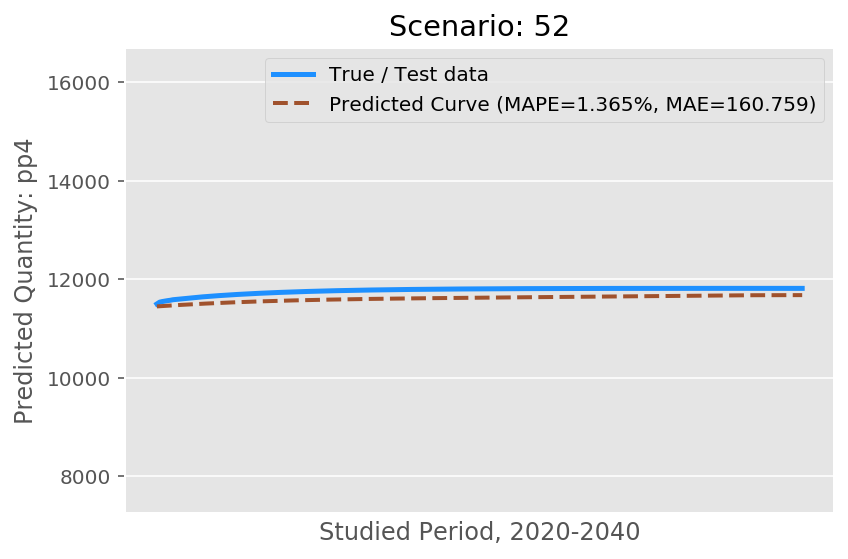

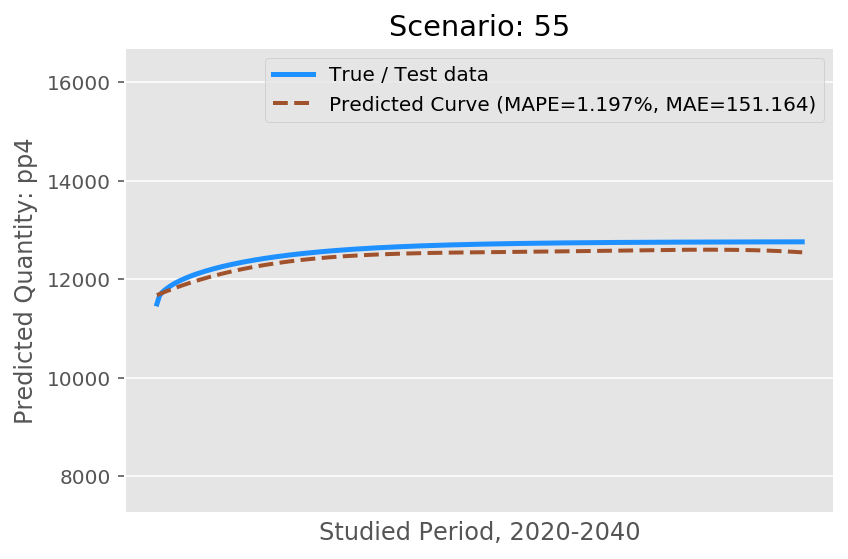

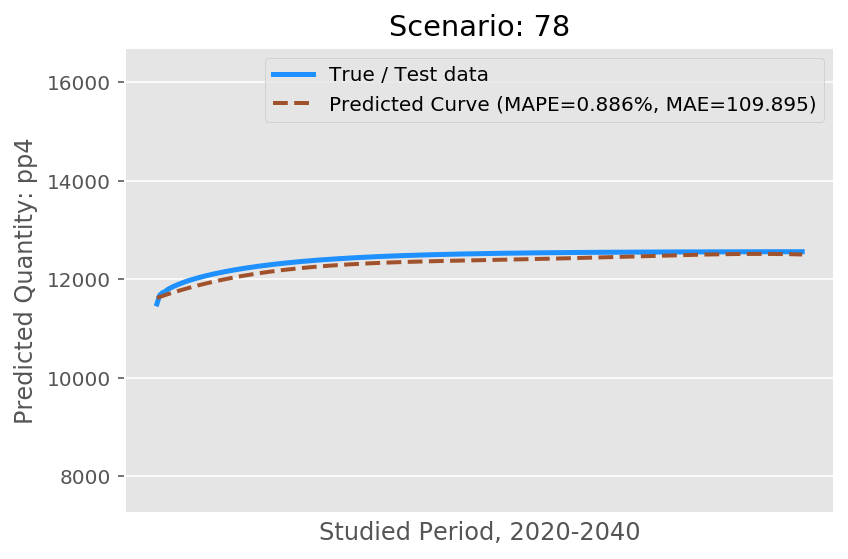

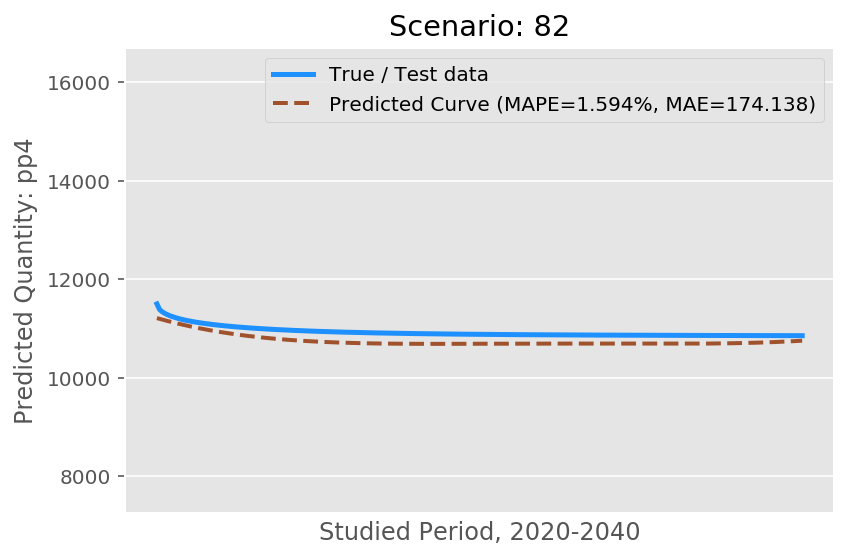

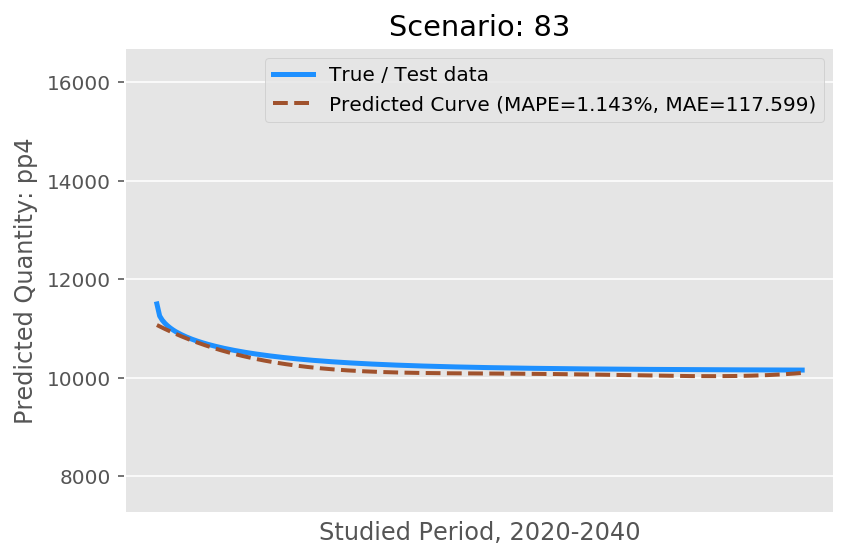

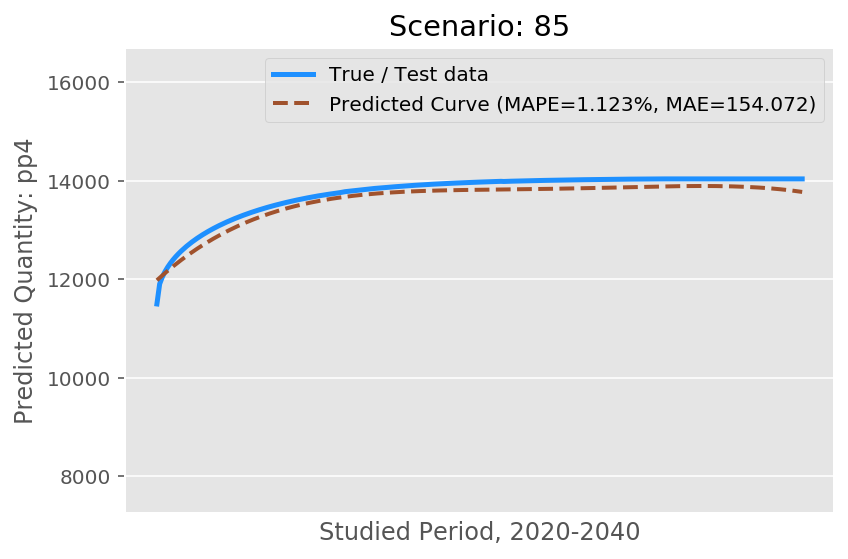

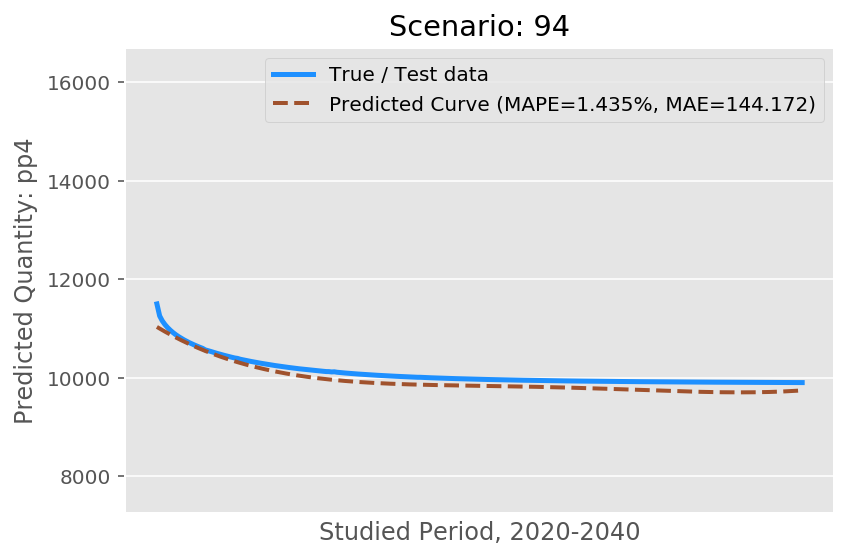

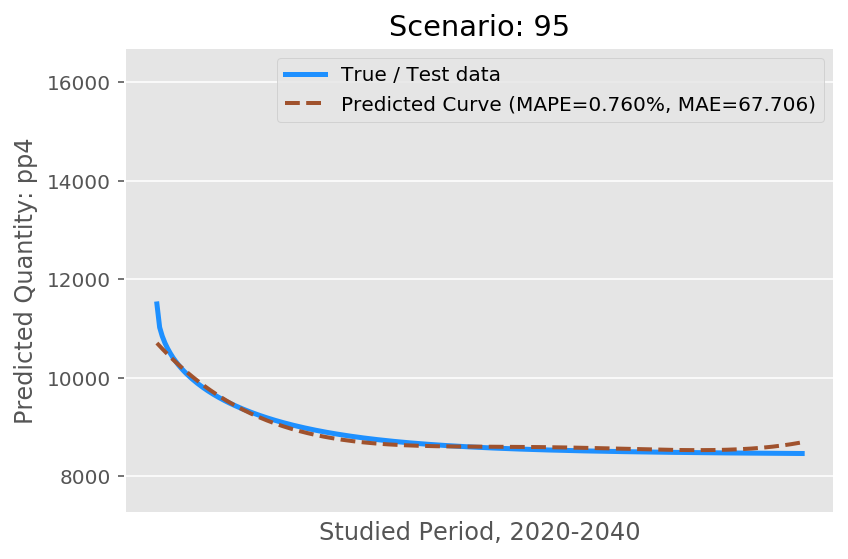

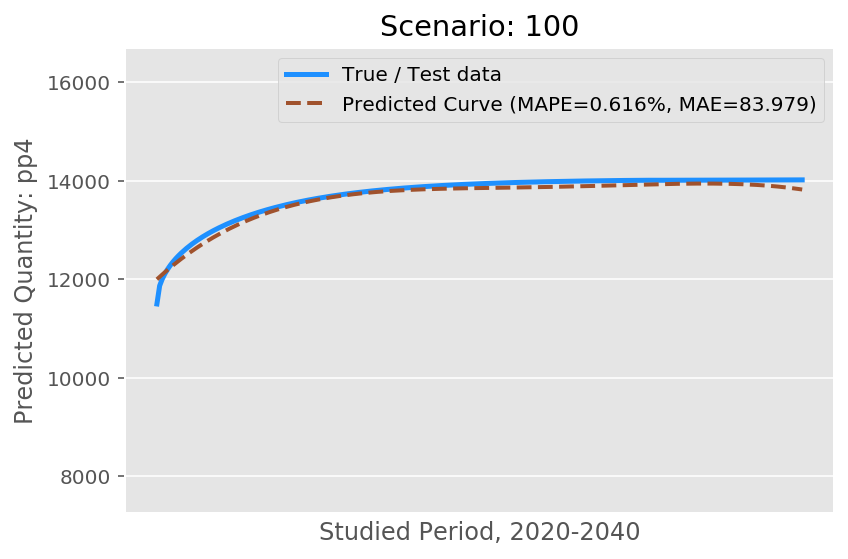

Quantity: pp5


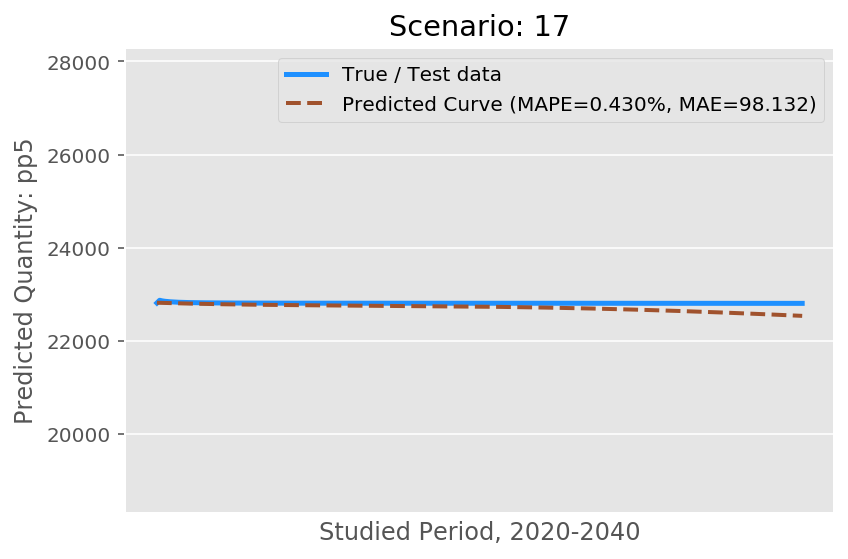

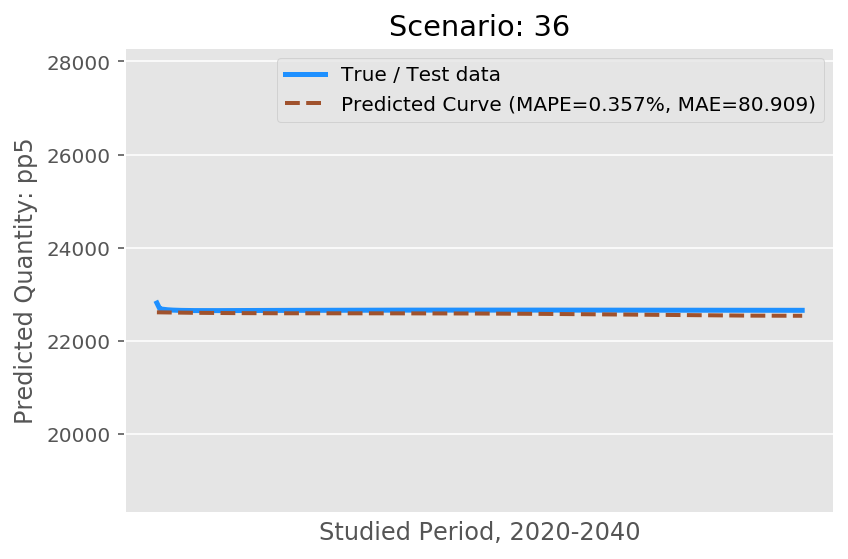

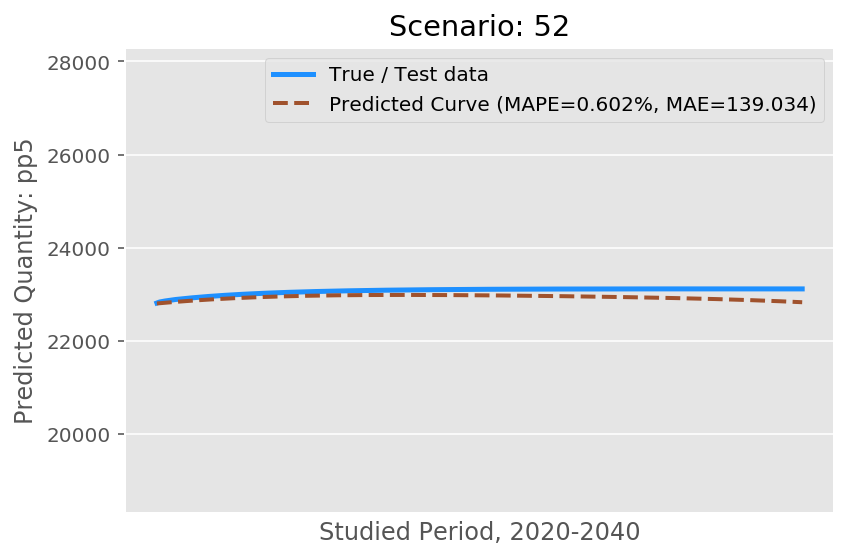

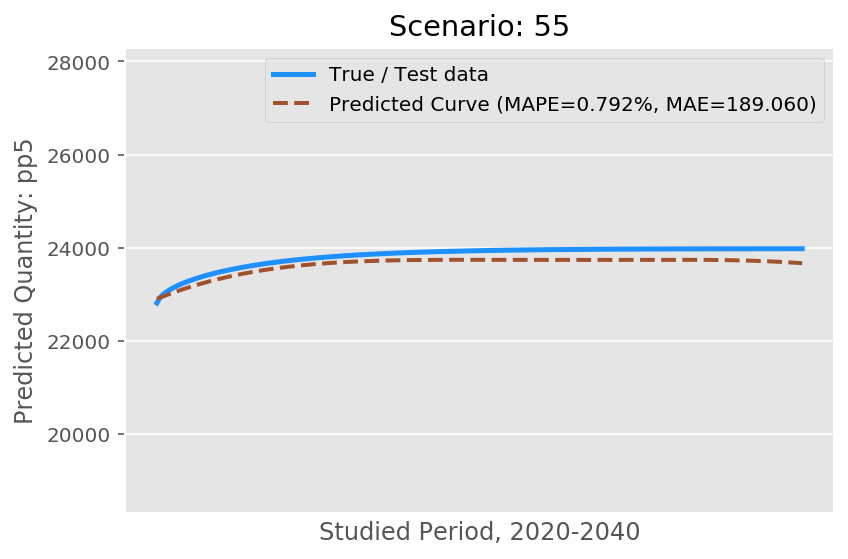

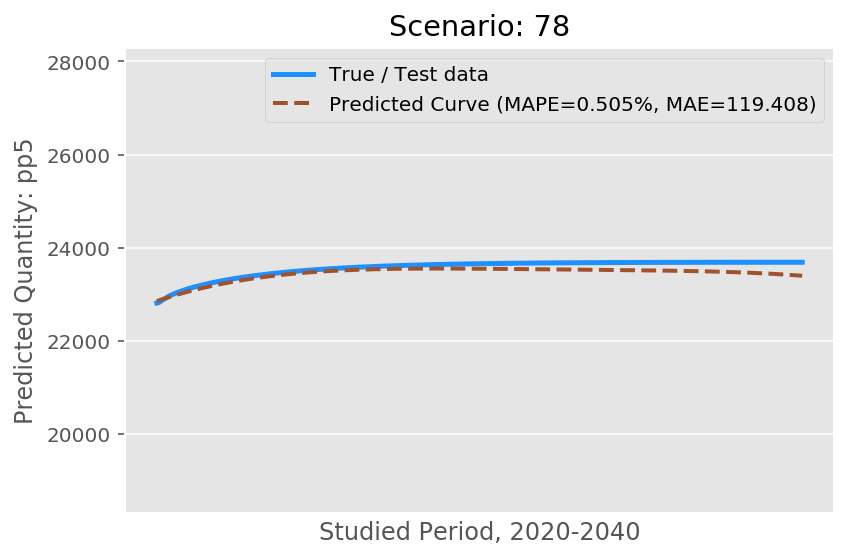

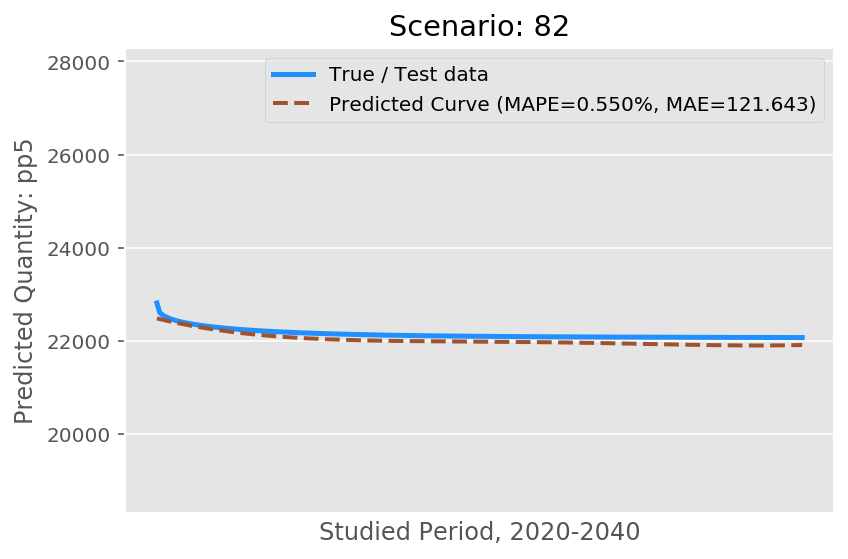

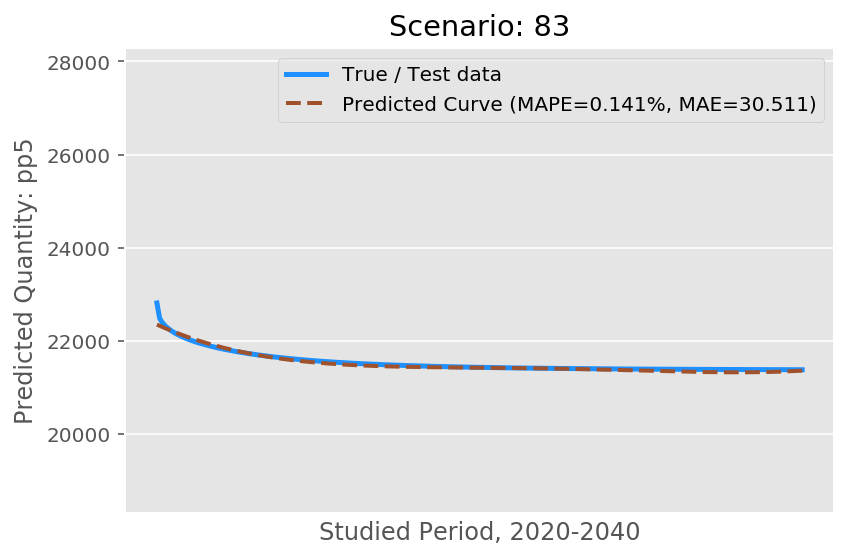

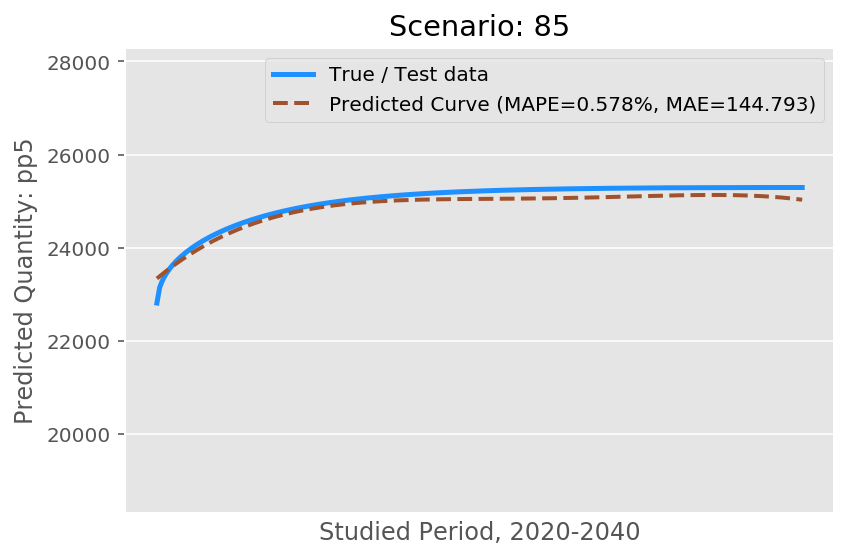

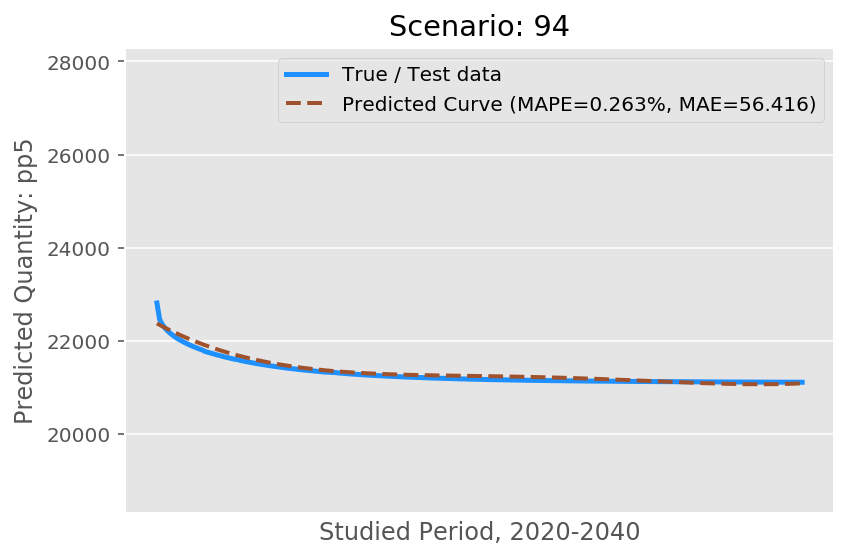

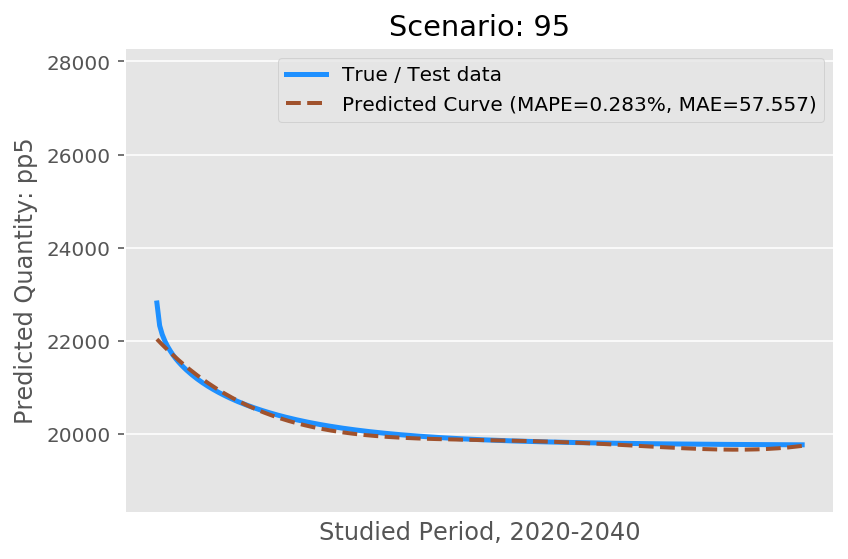

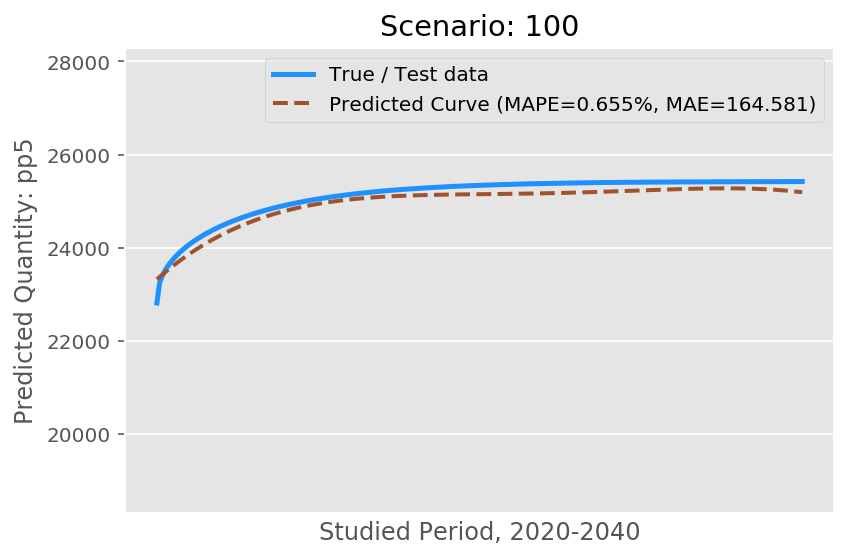

Quantity: pp6


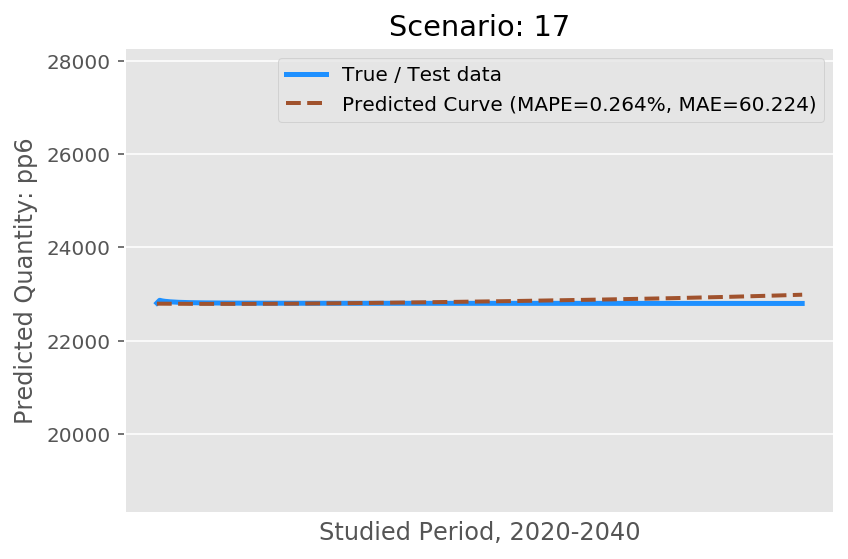

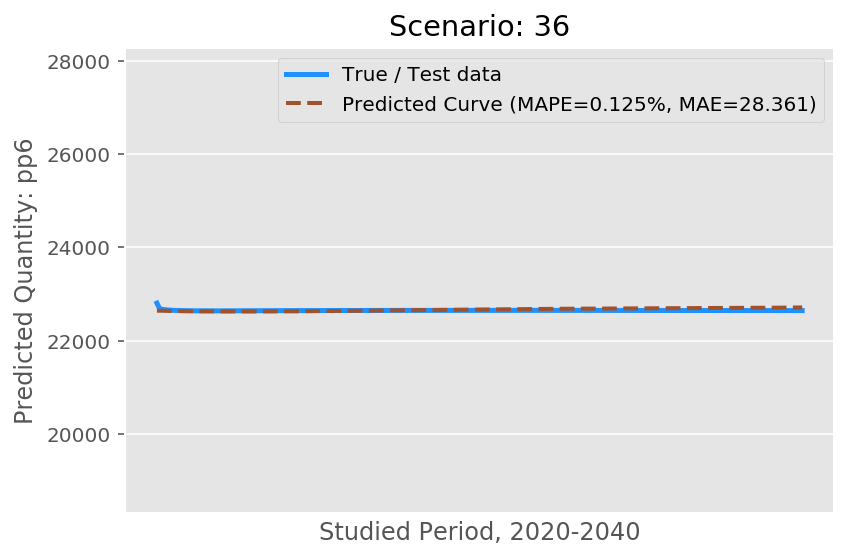

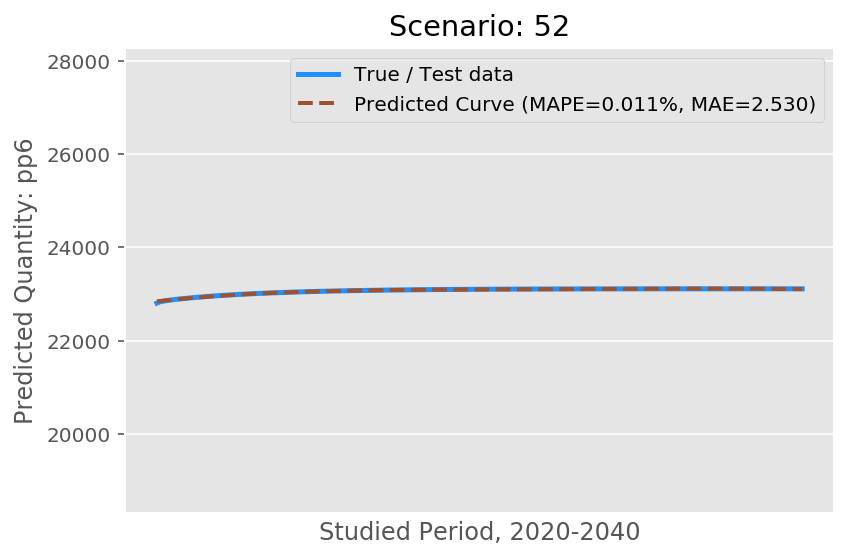

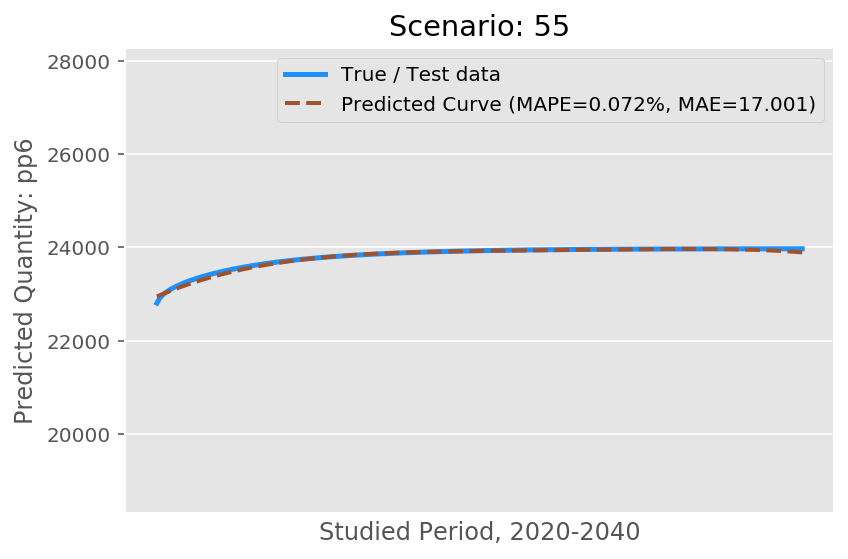

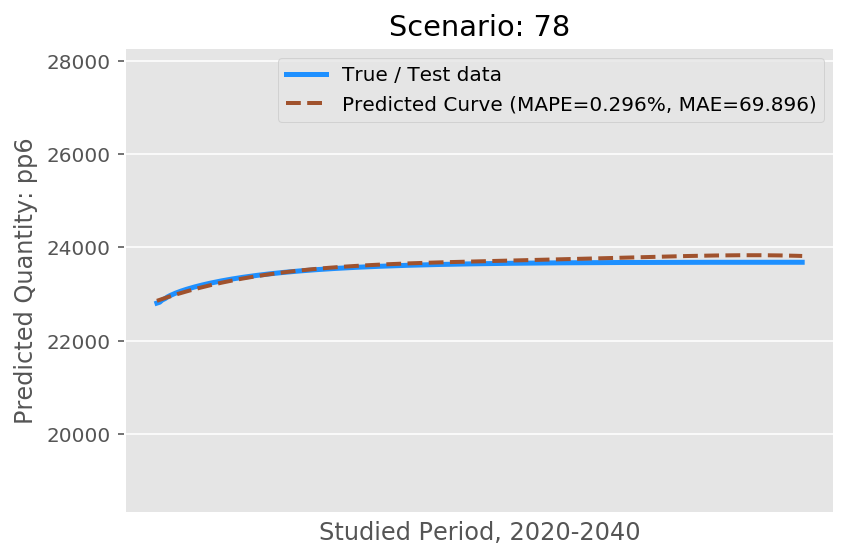

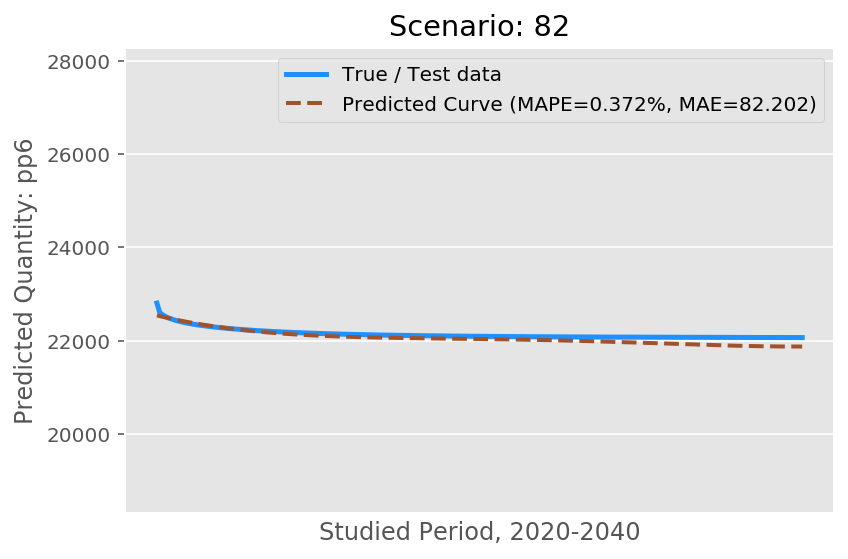

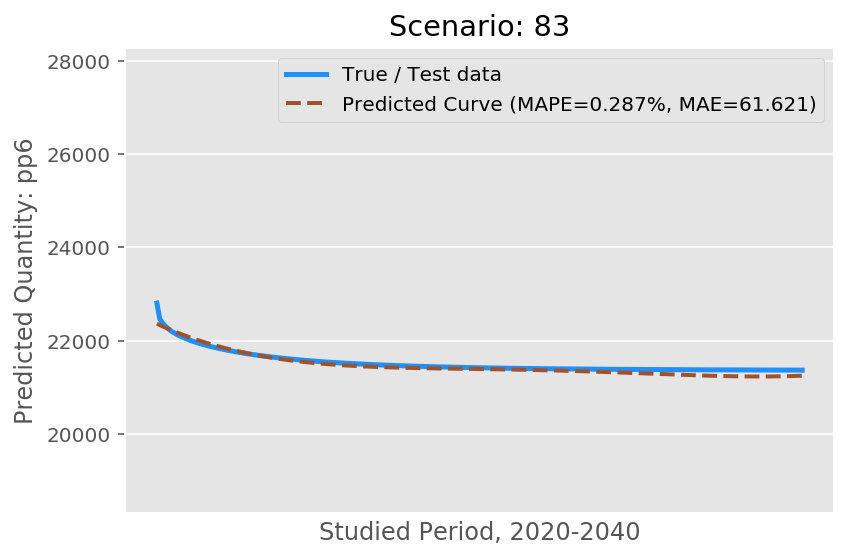

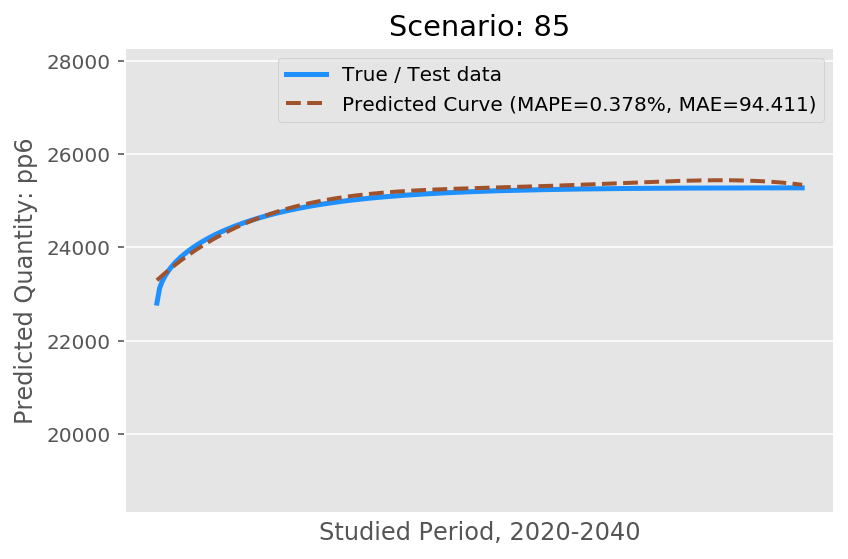

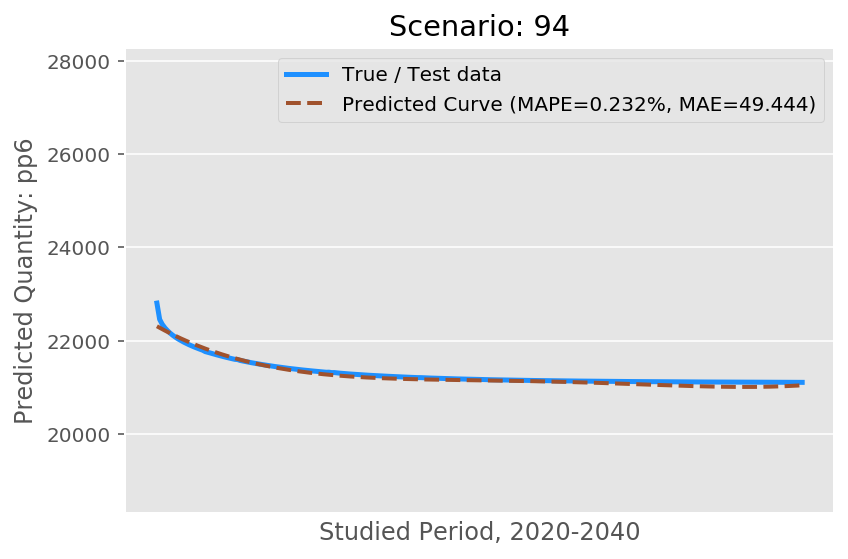

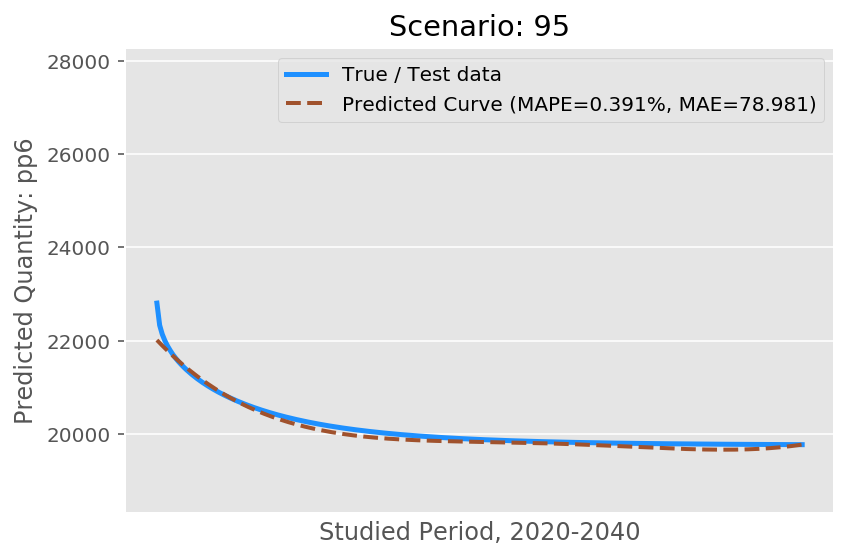

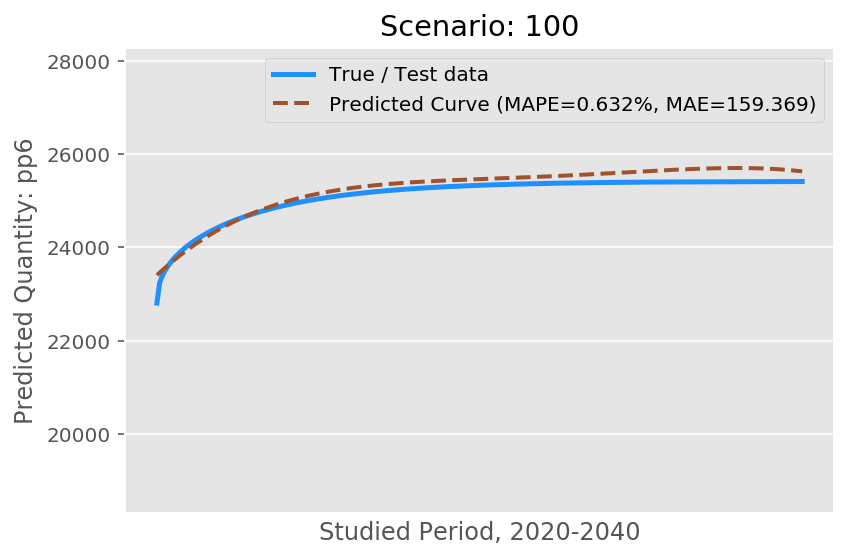

Quantity: pt1


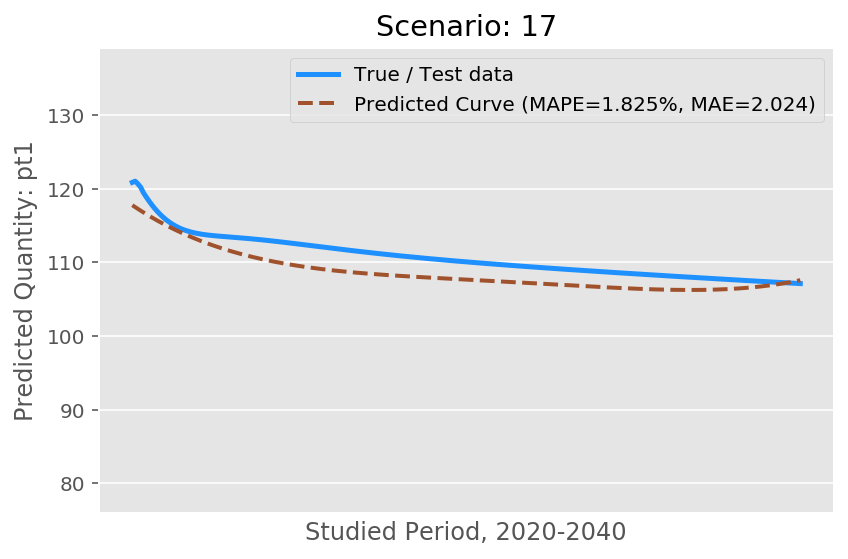

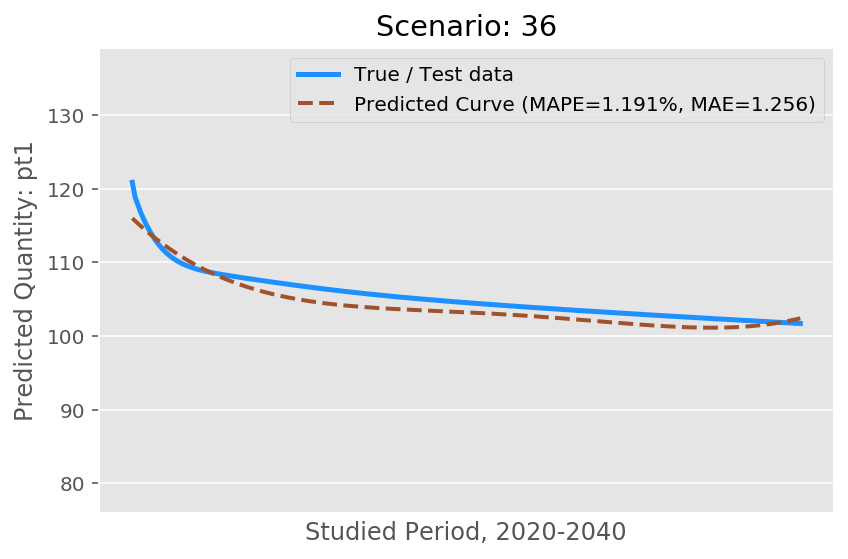

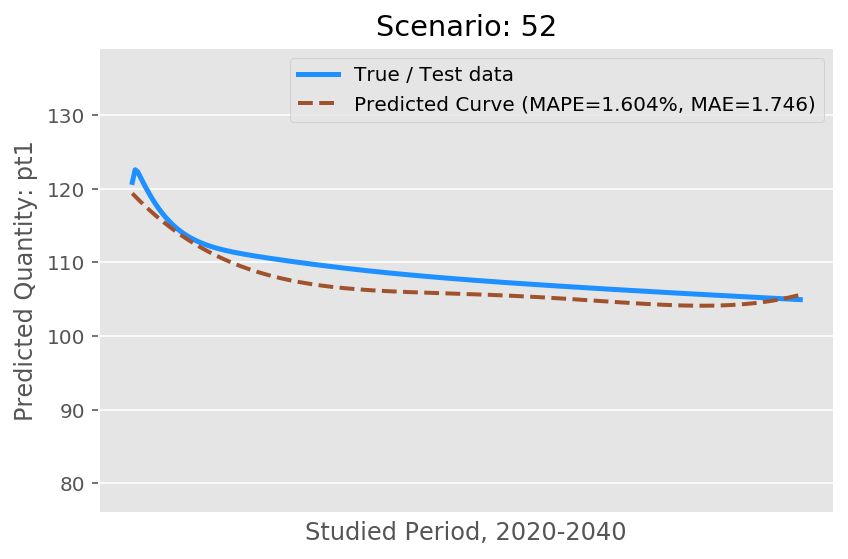

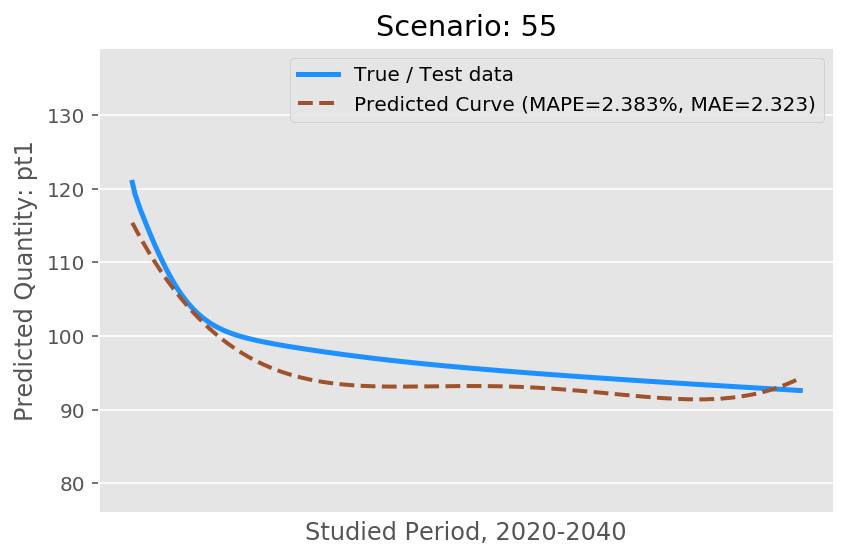

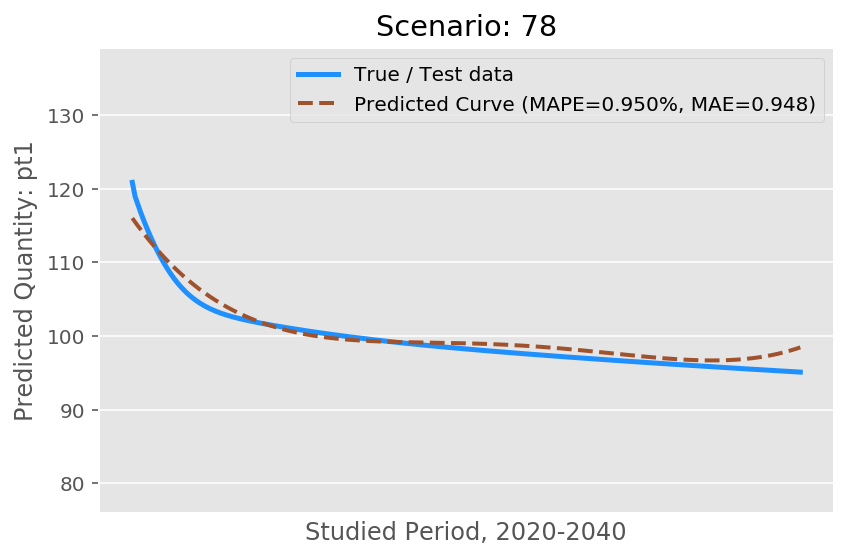

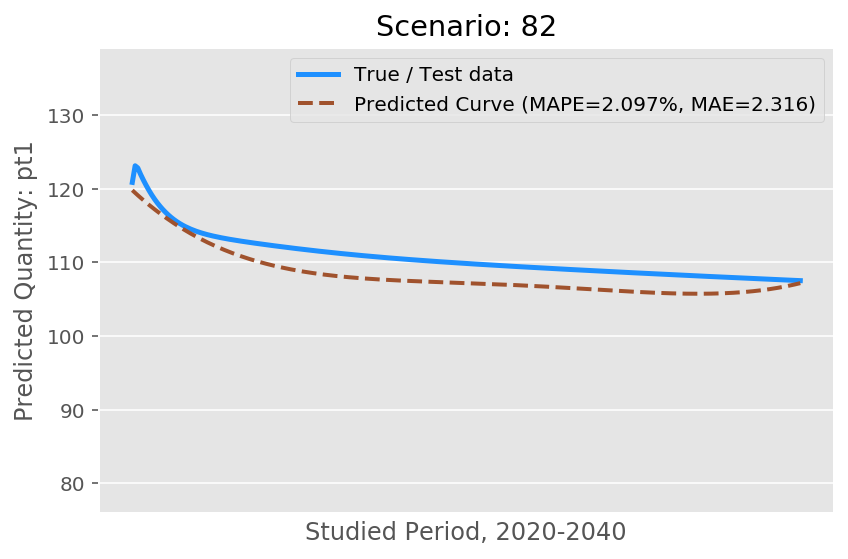

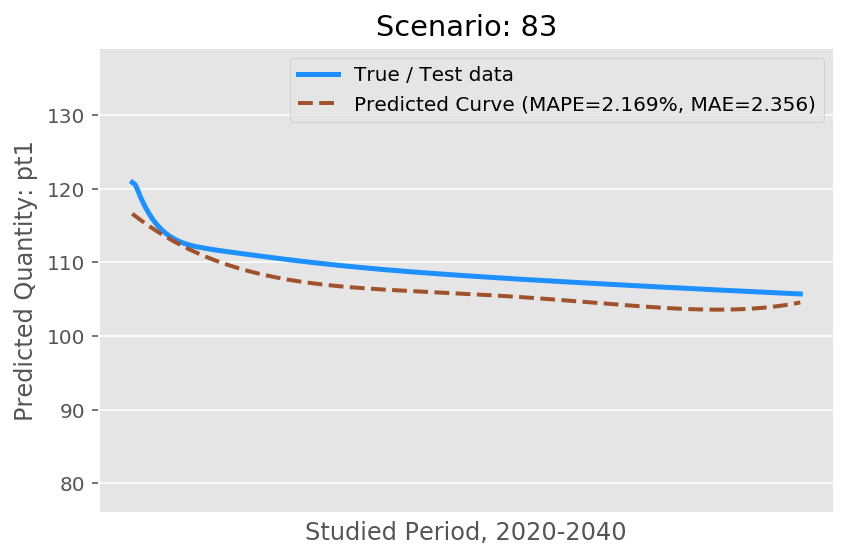

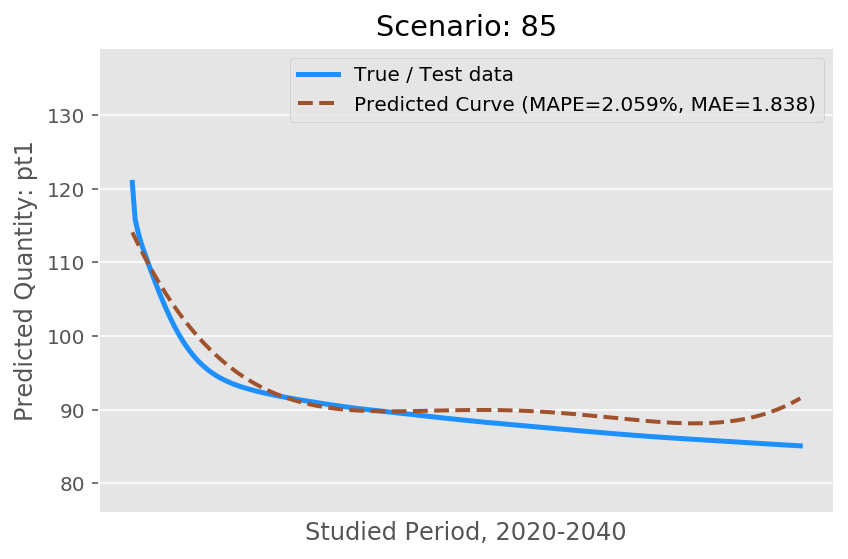

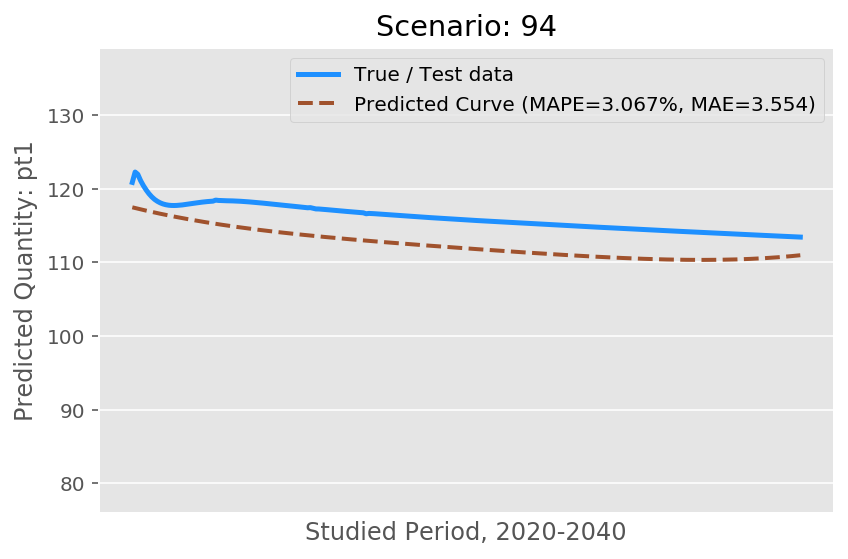

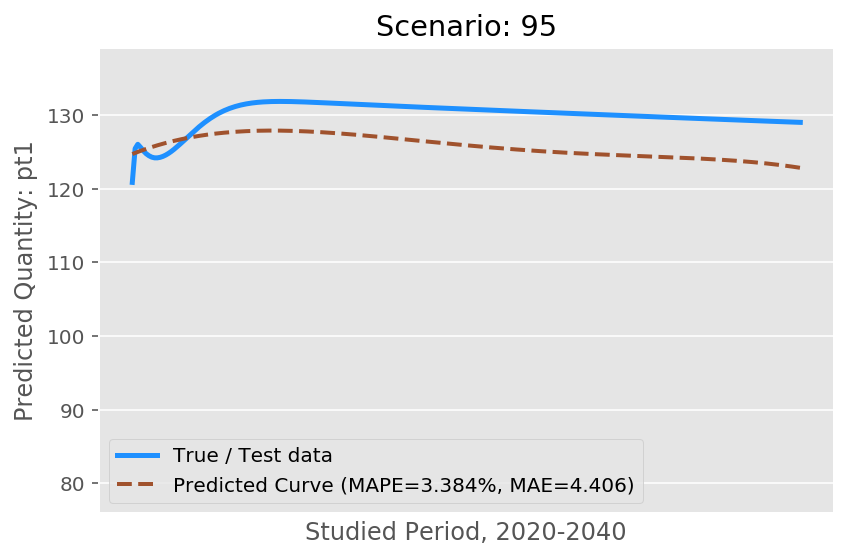

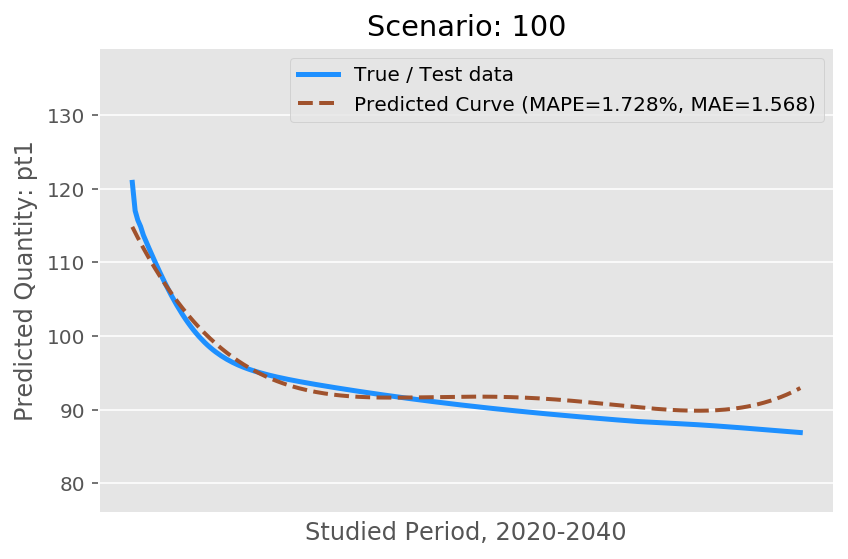

Quantity: pt2


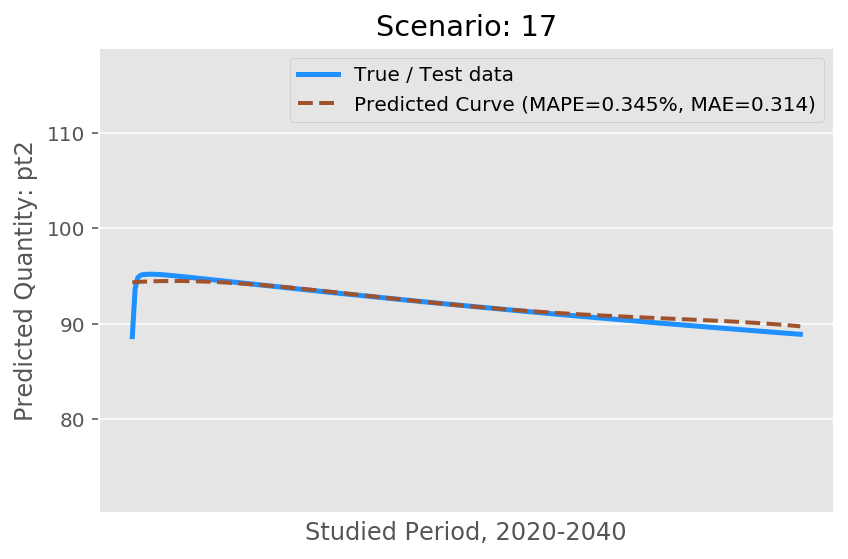

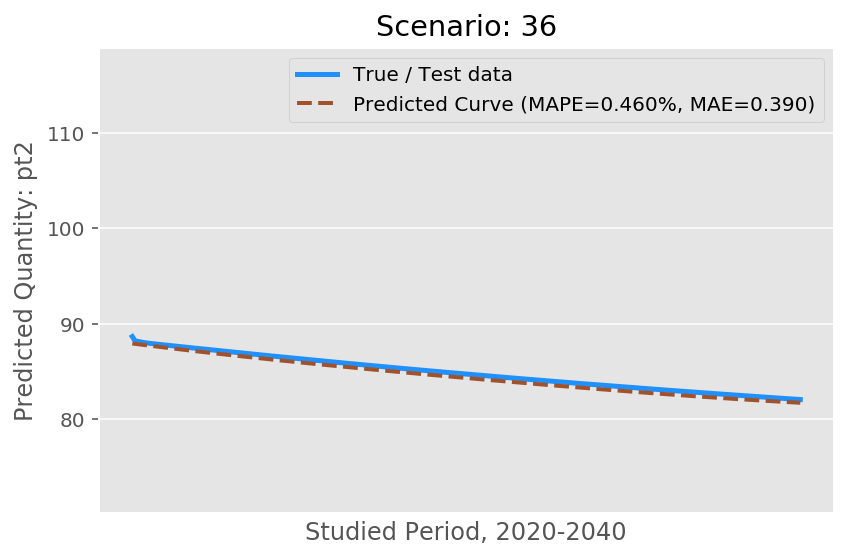

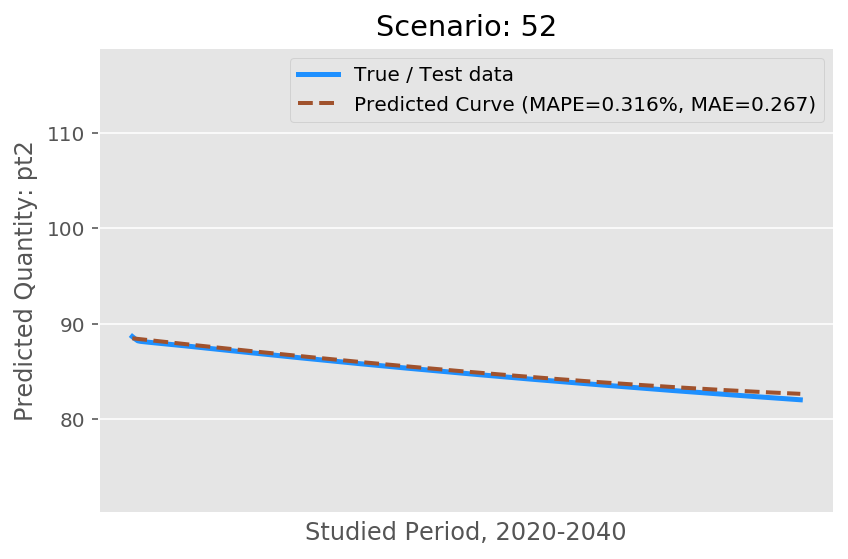

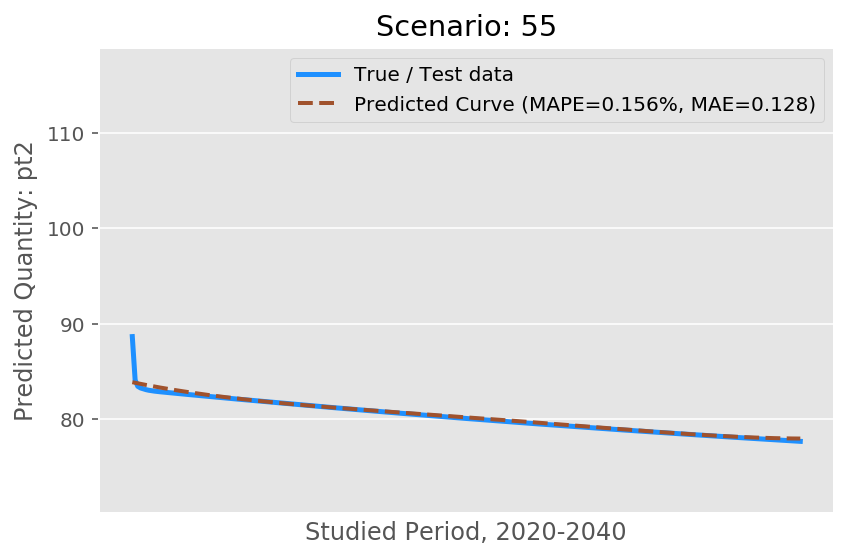

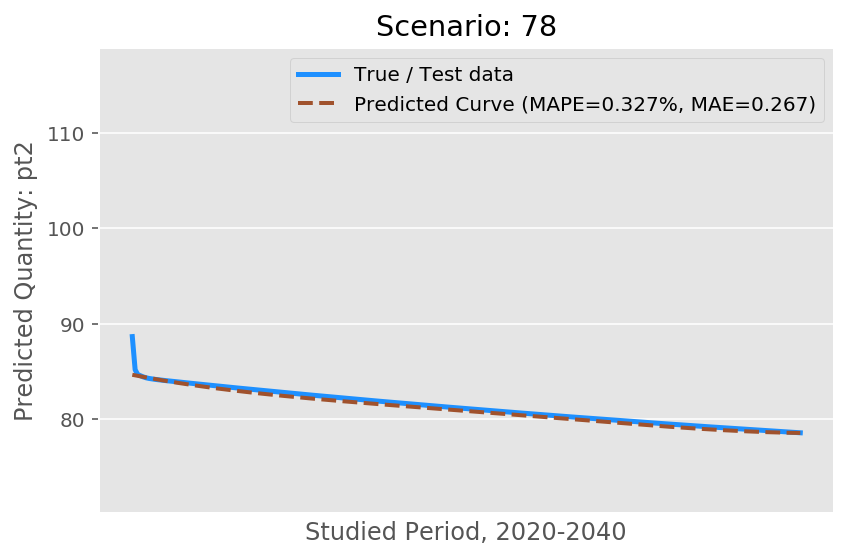

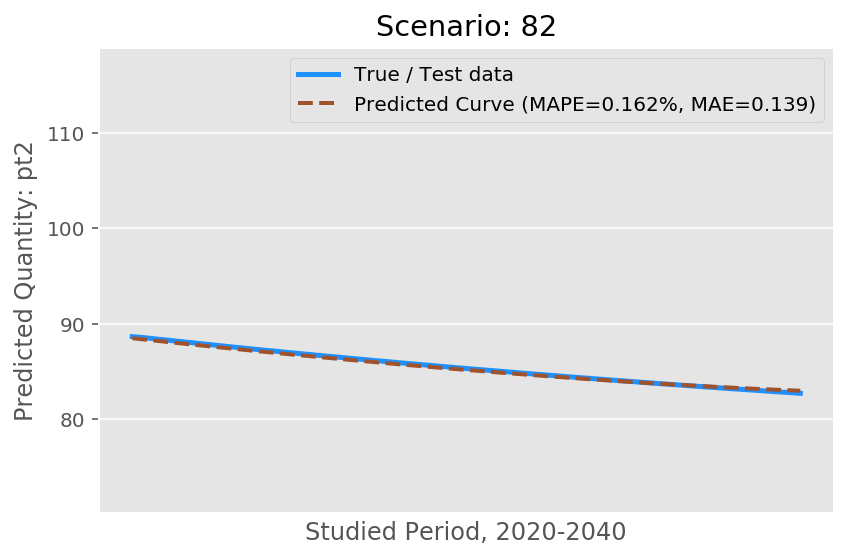

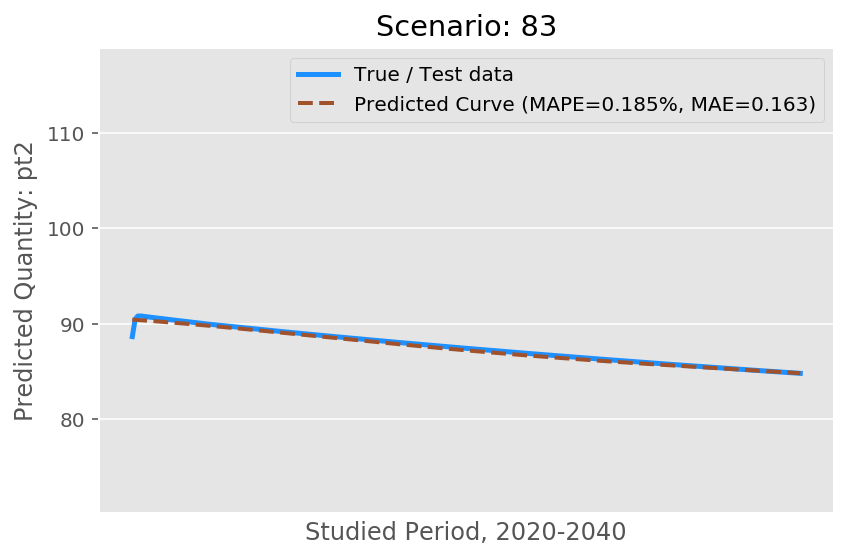

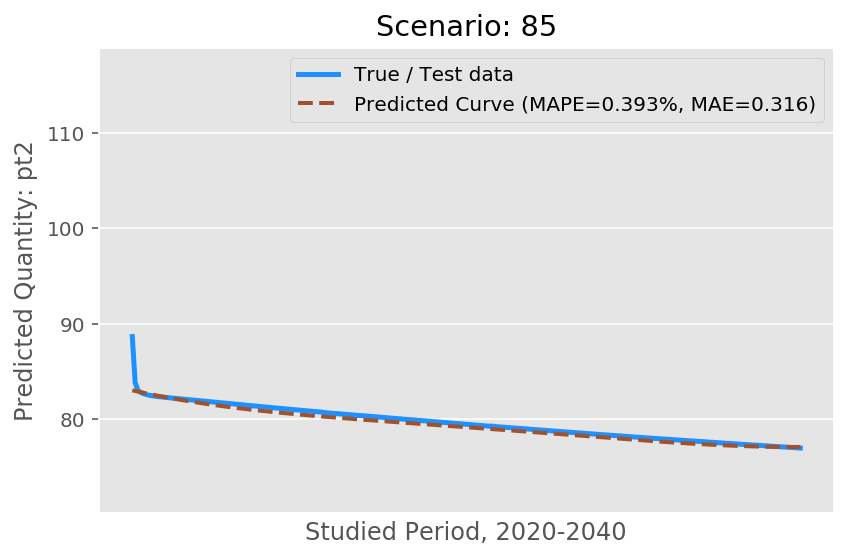

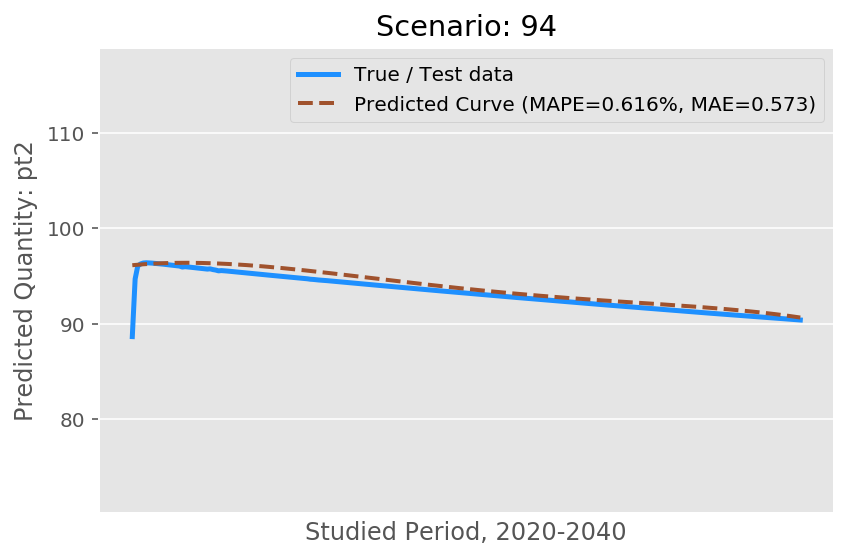

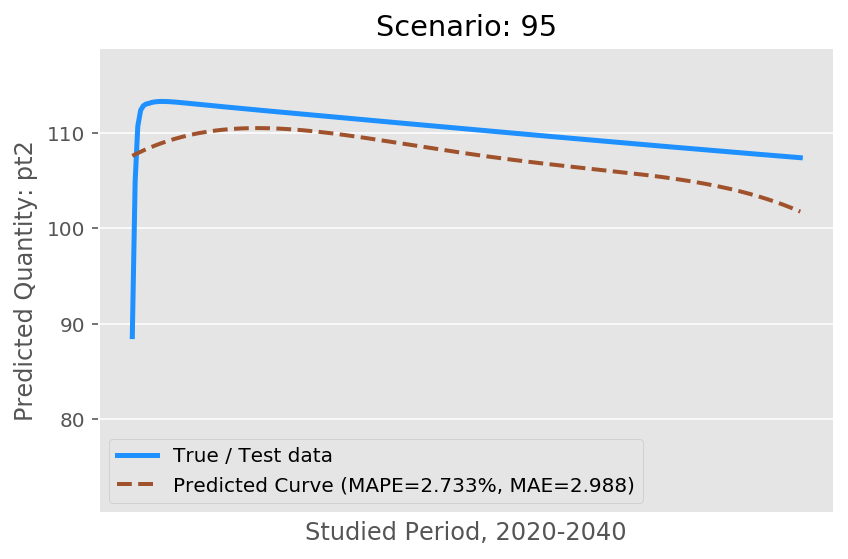

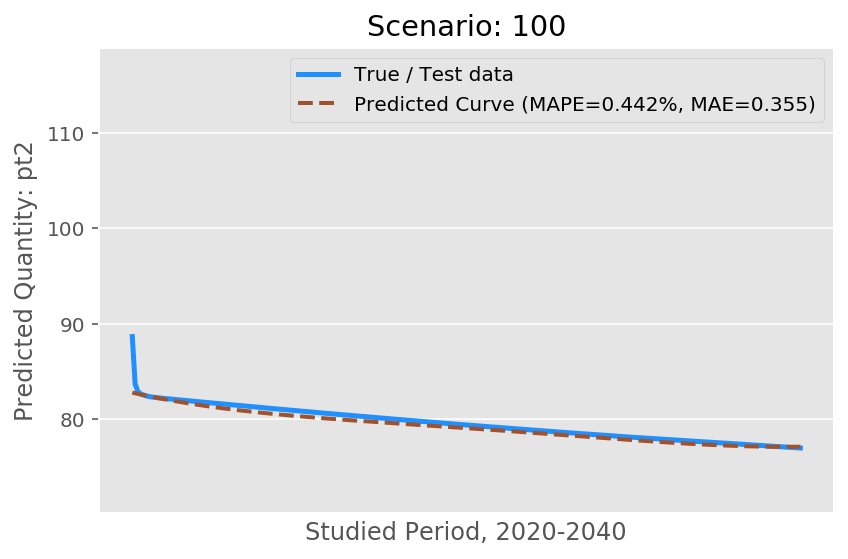

Quantity: pt3


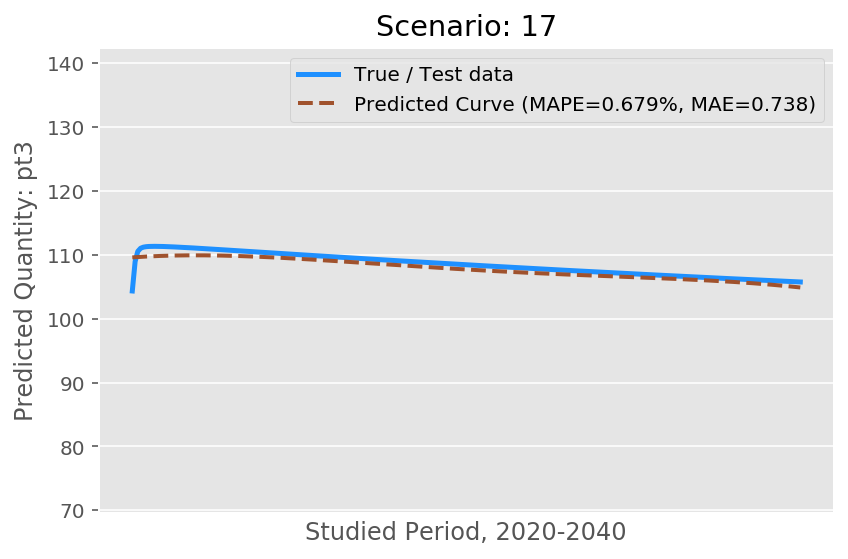

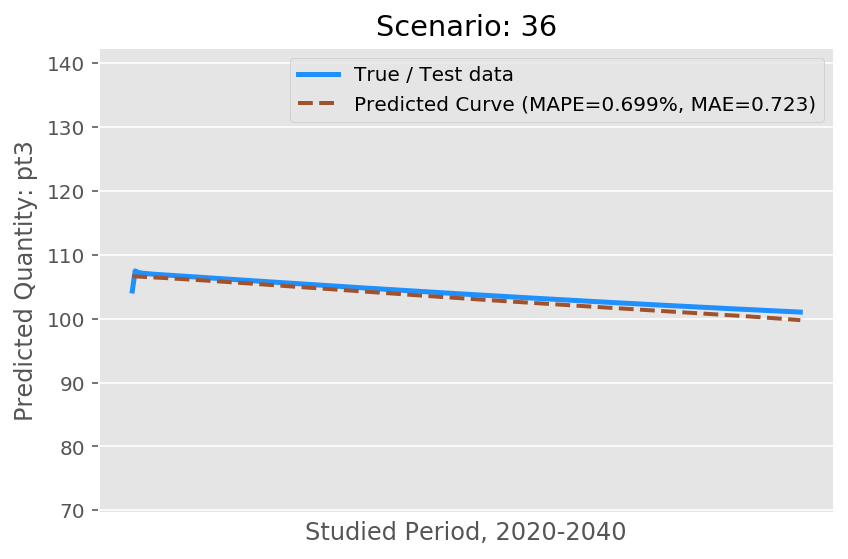

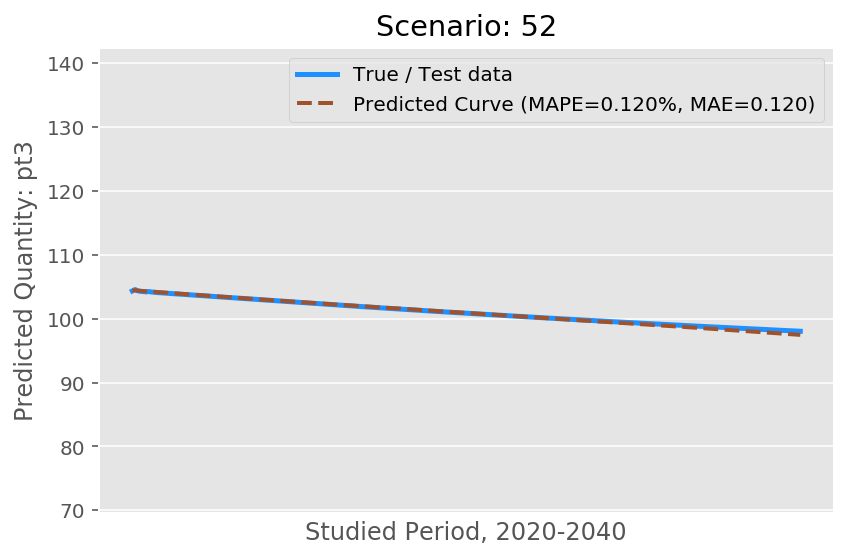

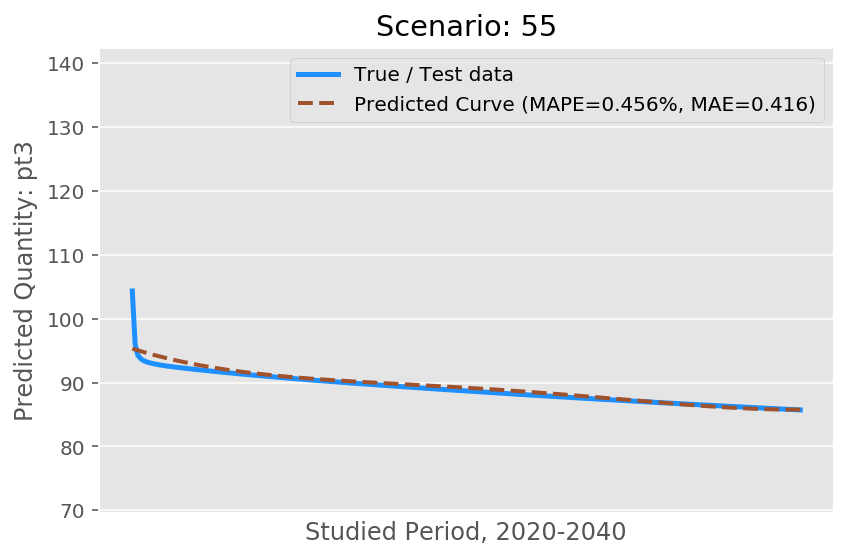

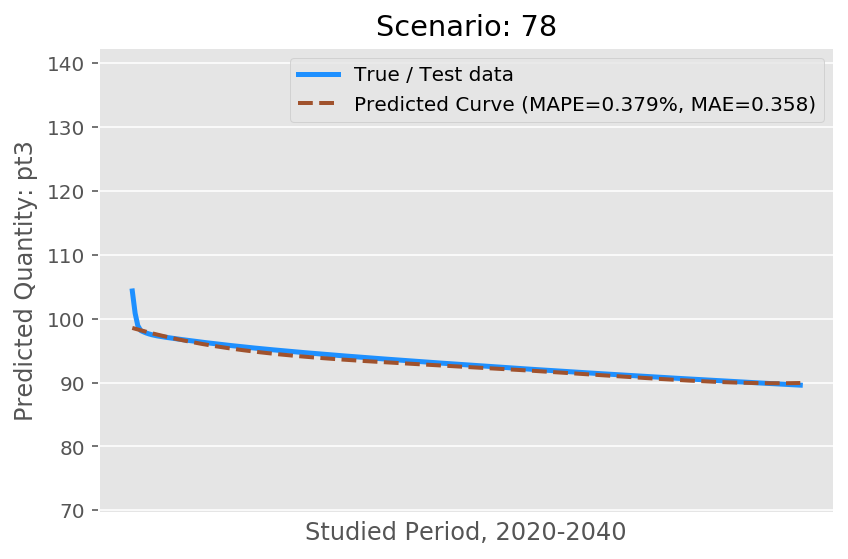

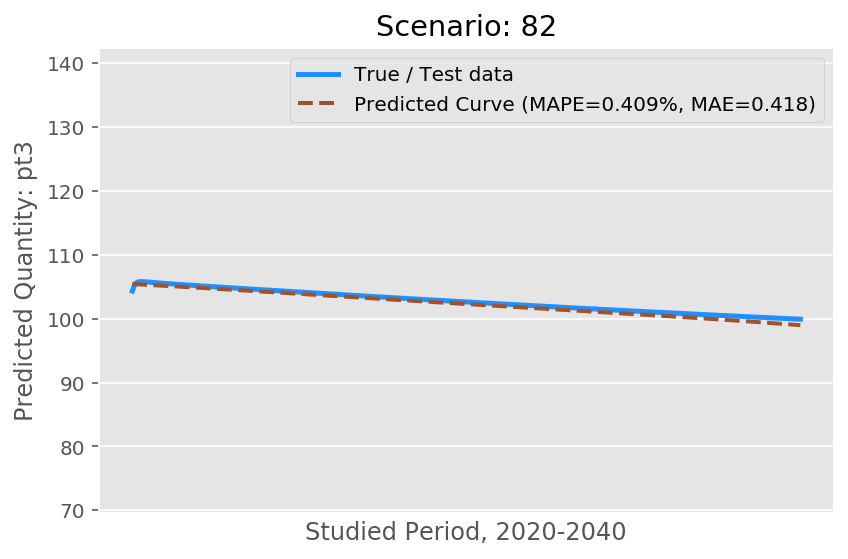

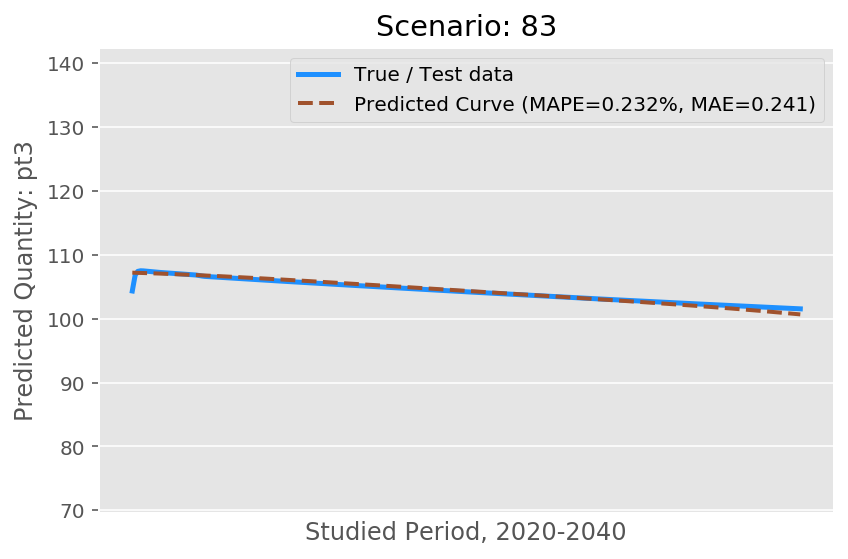

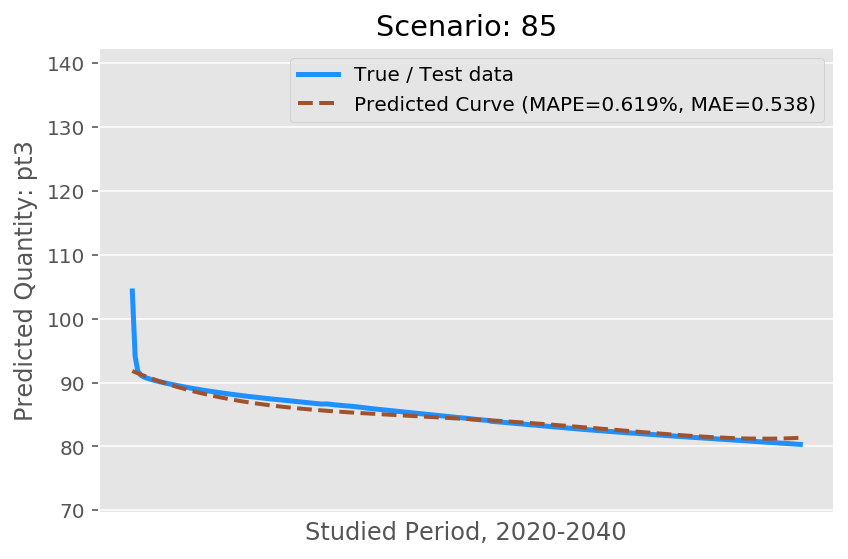

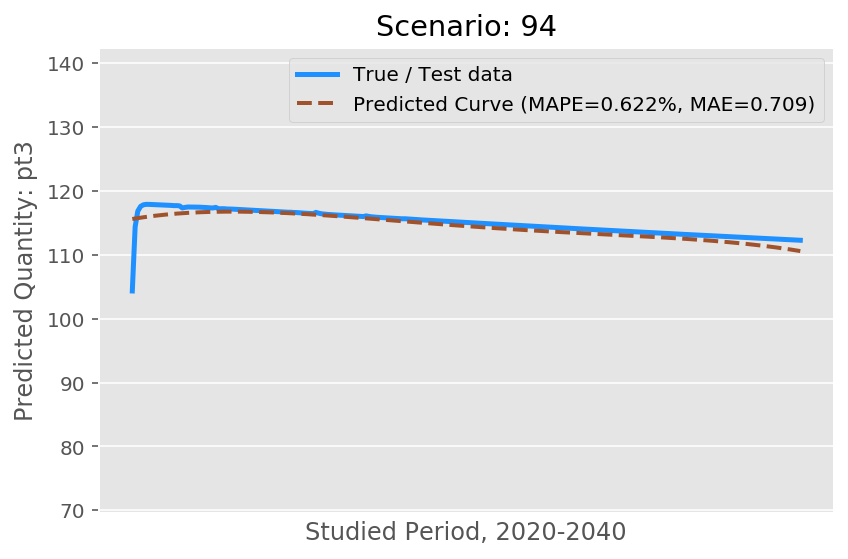

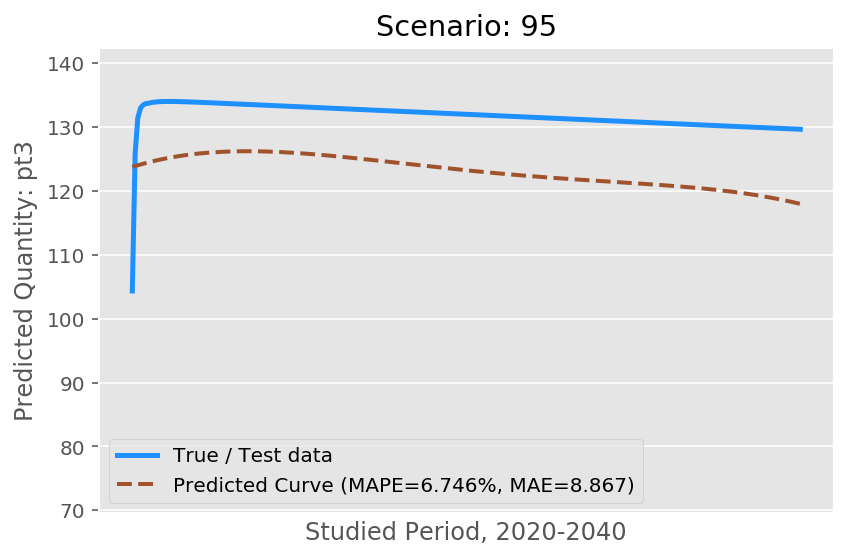

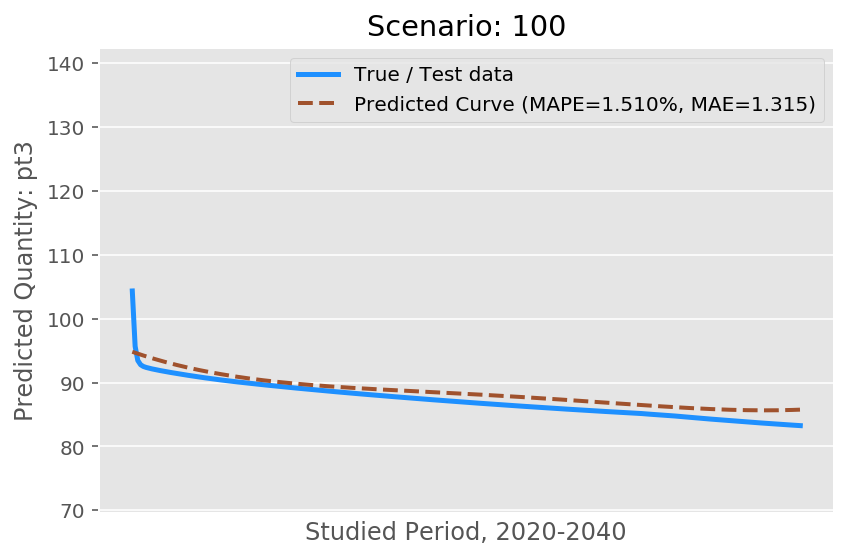

Quantity: pt4


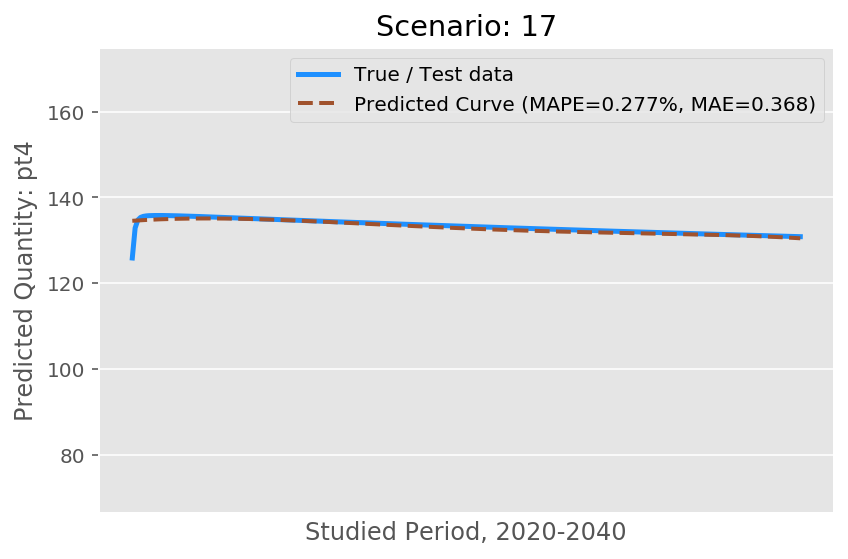

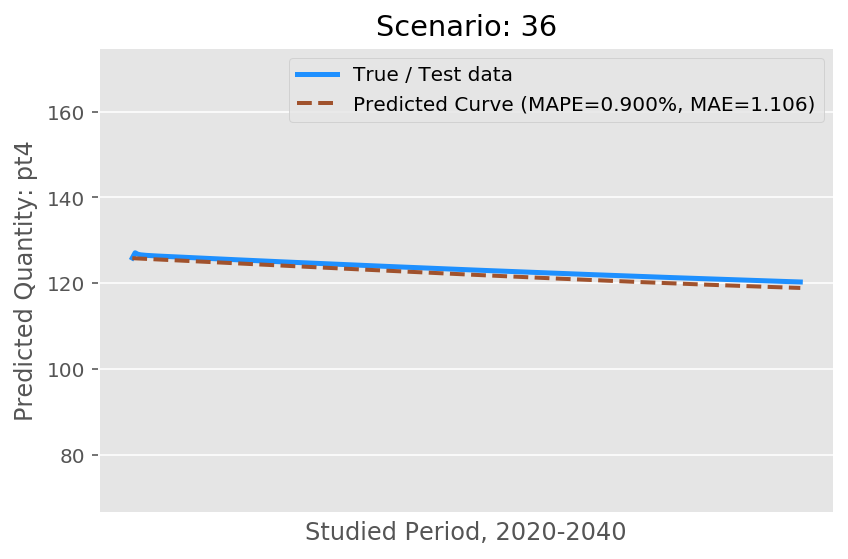

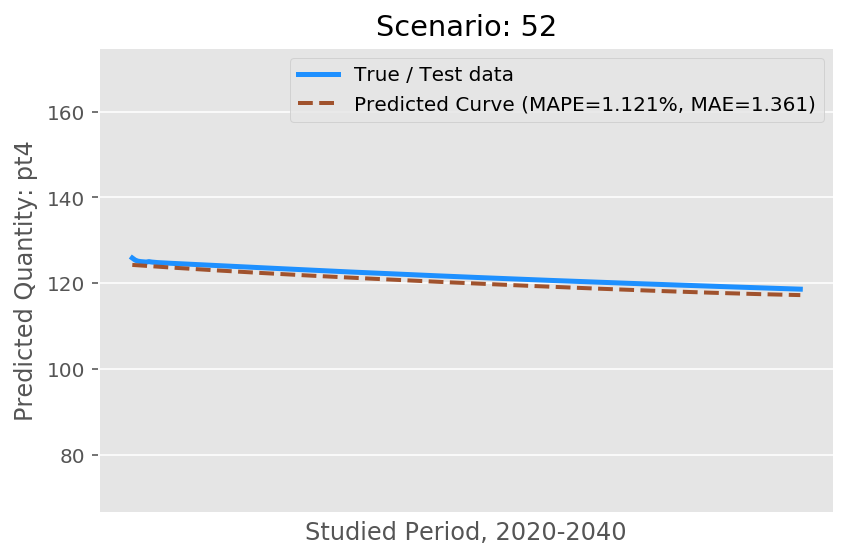

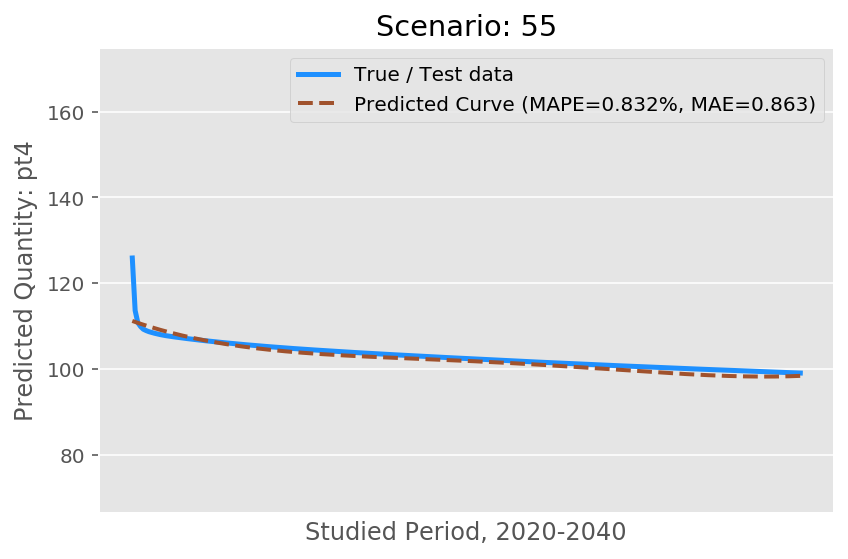

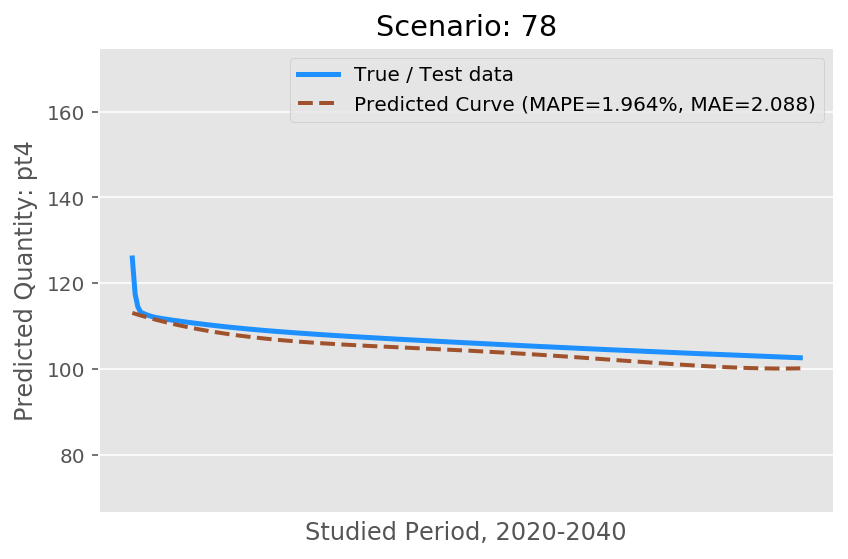

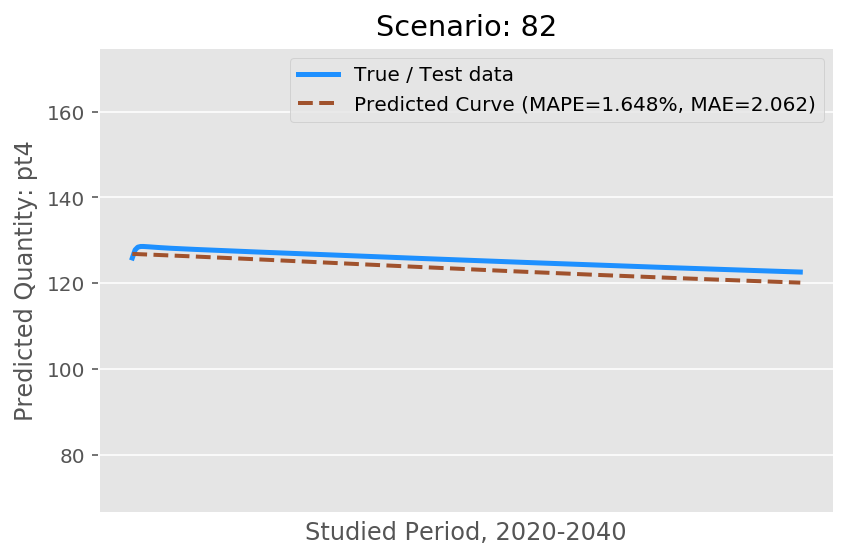

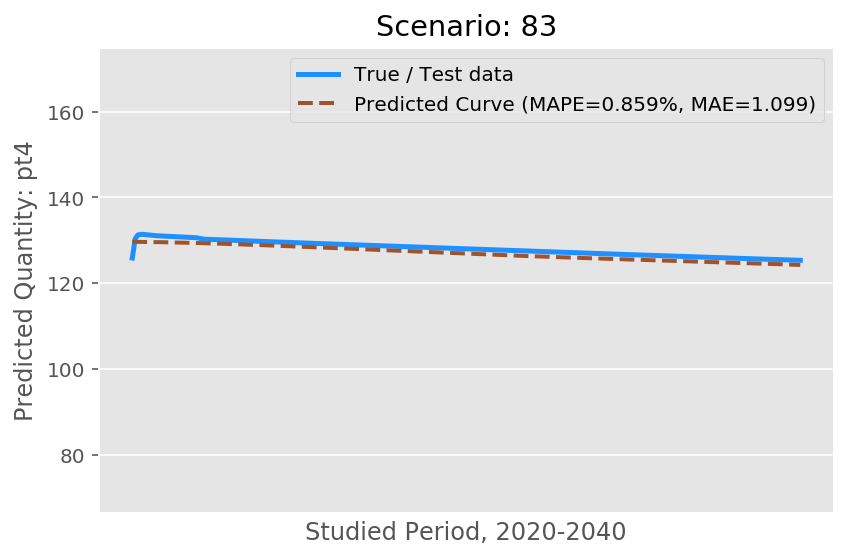

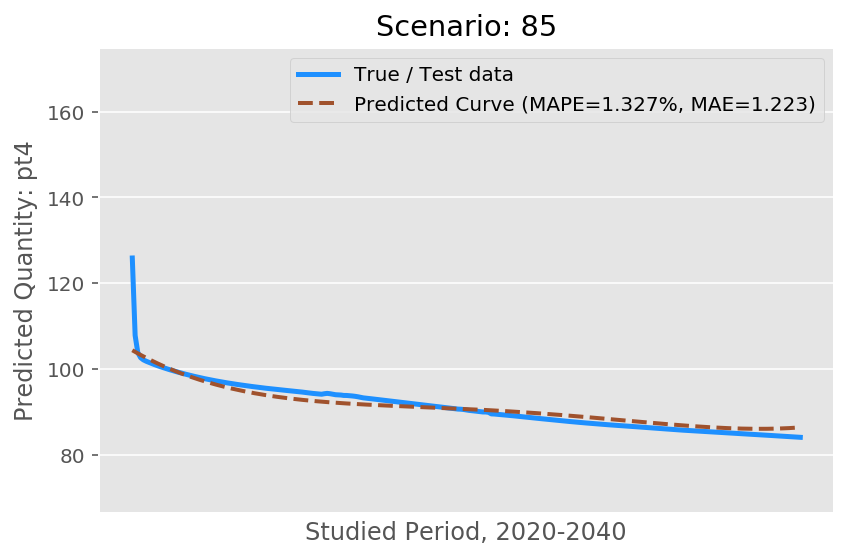

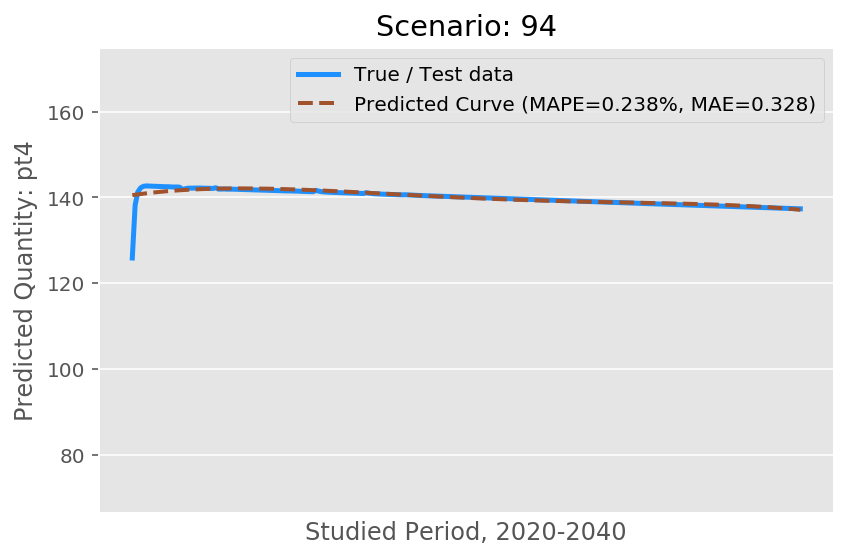

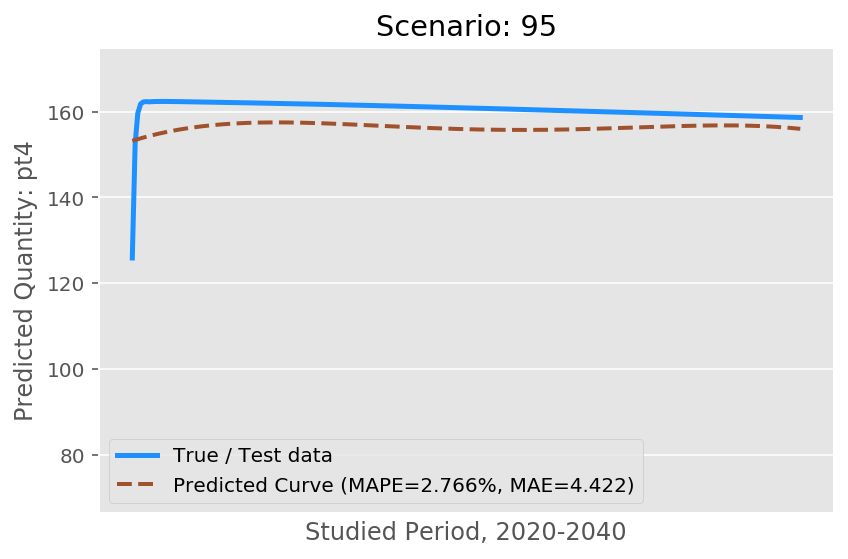

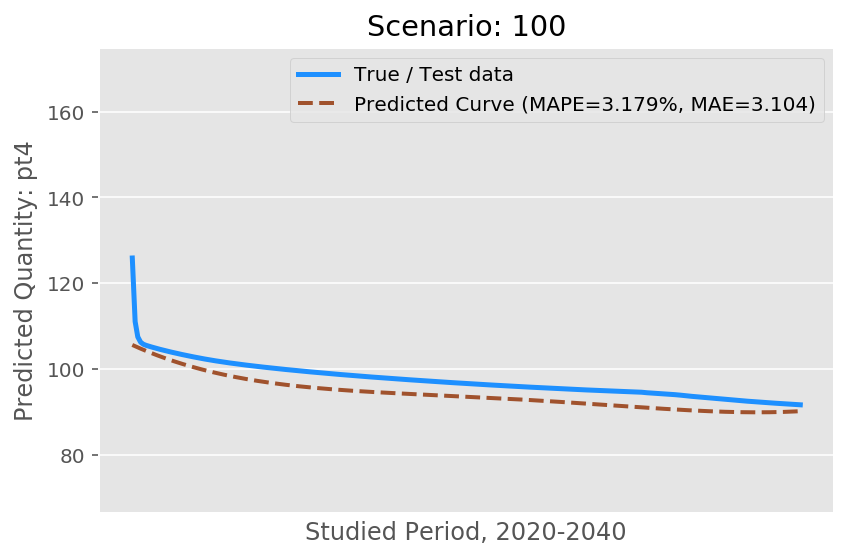

Quantity: pt5


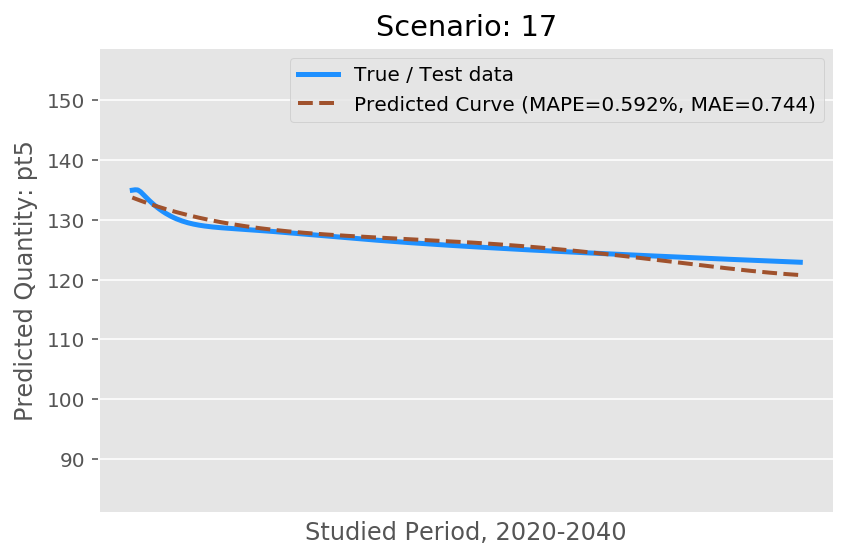

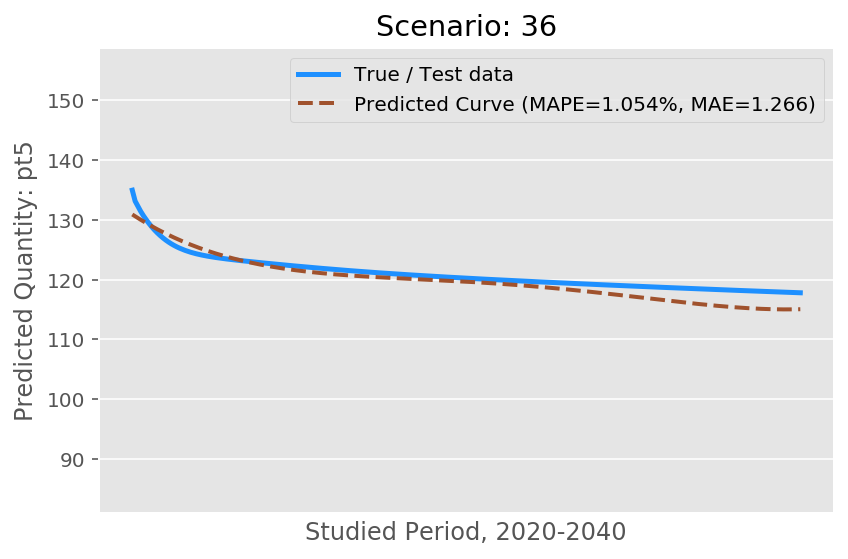

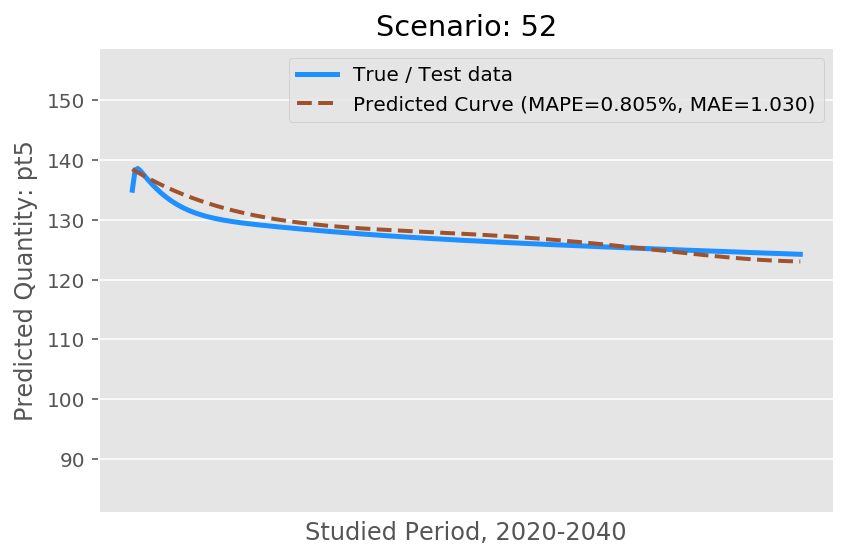

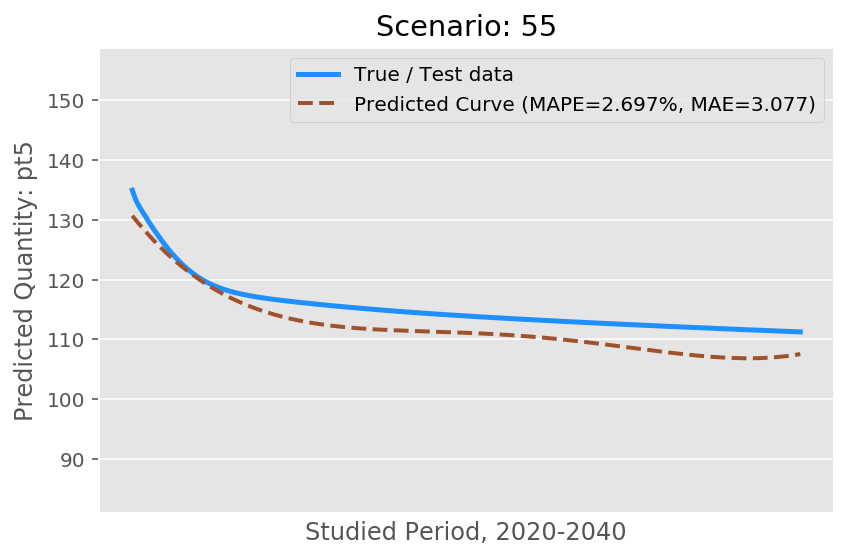

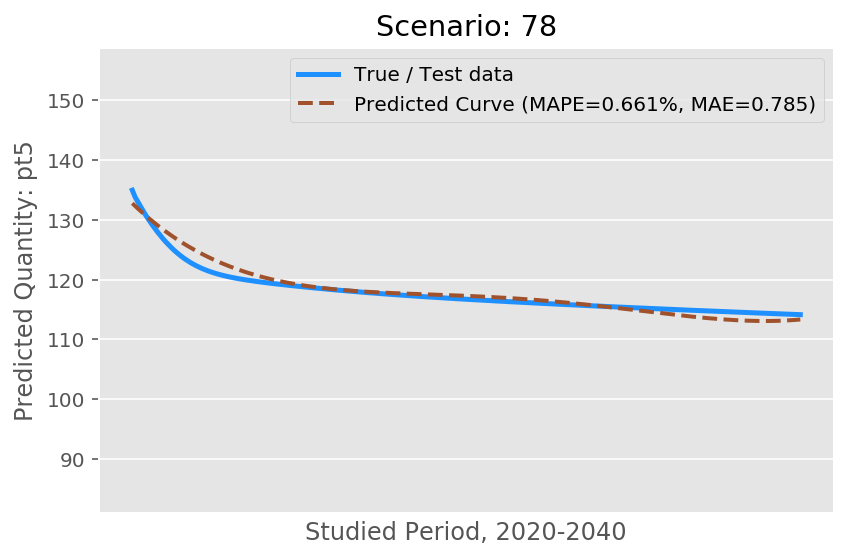

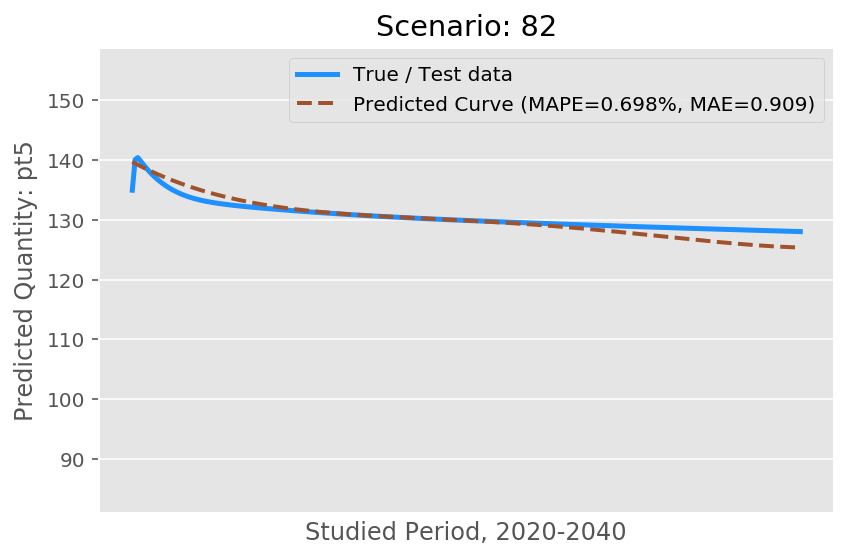

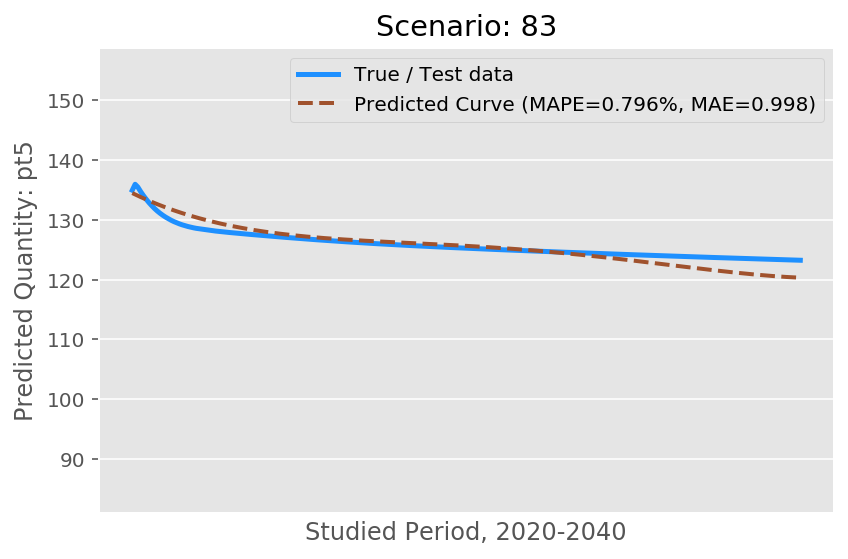

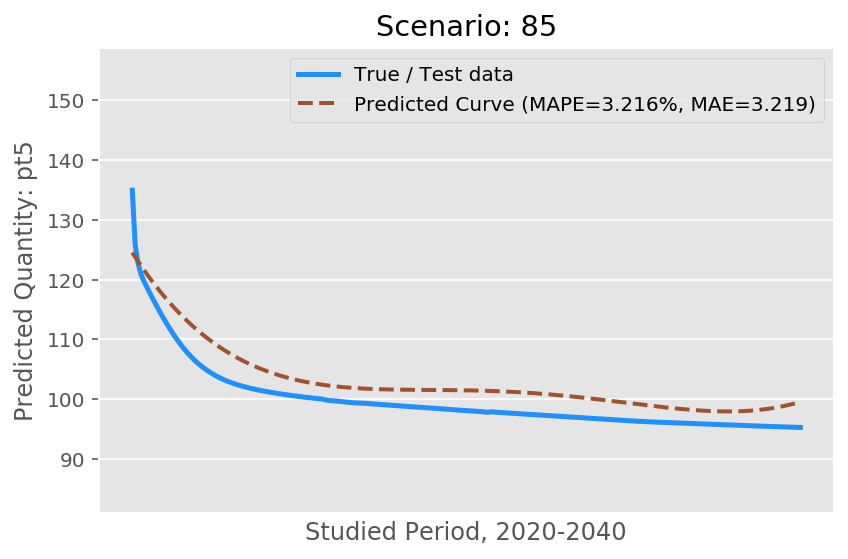

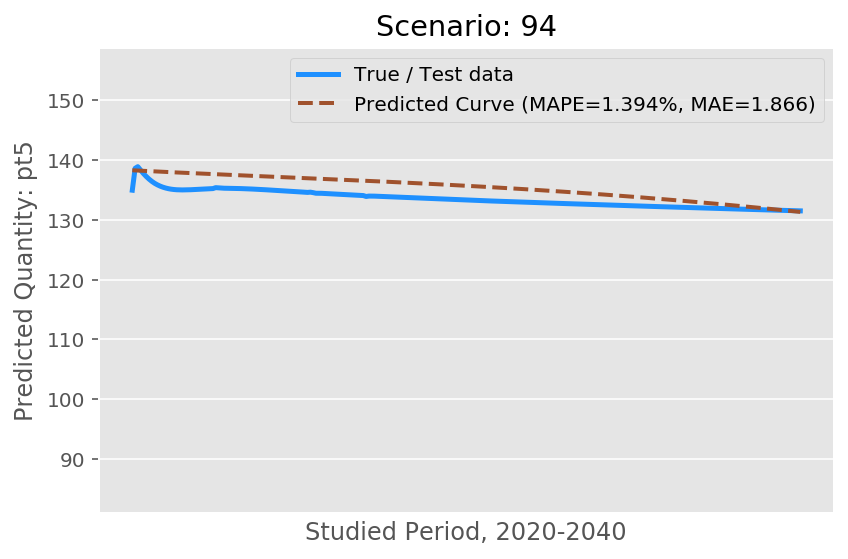

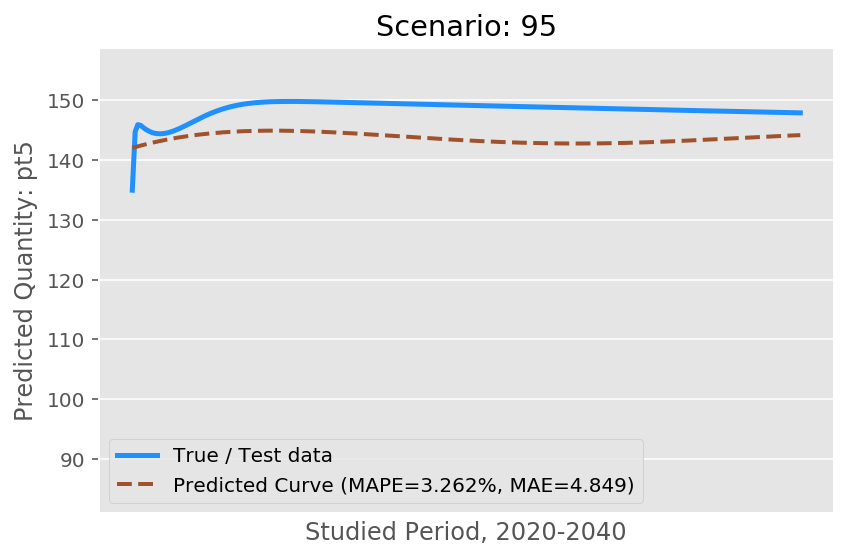

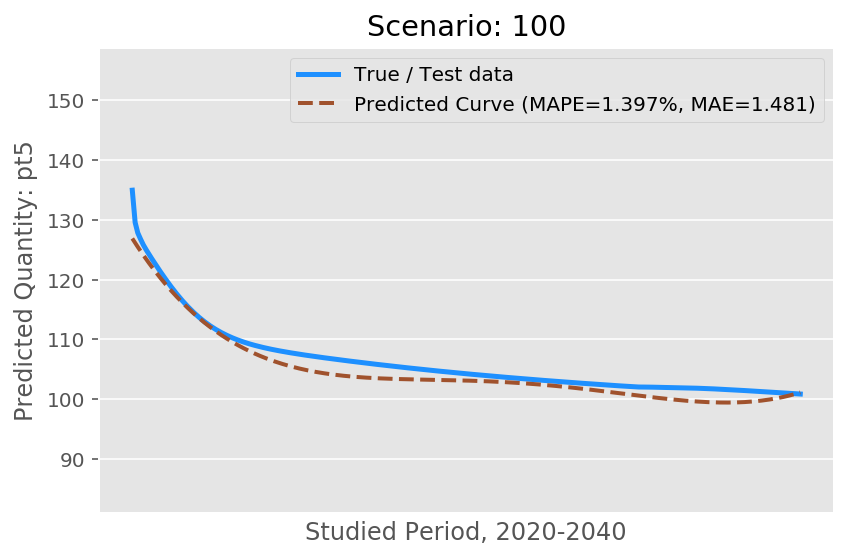

Quantity: pt6


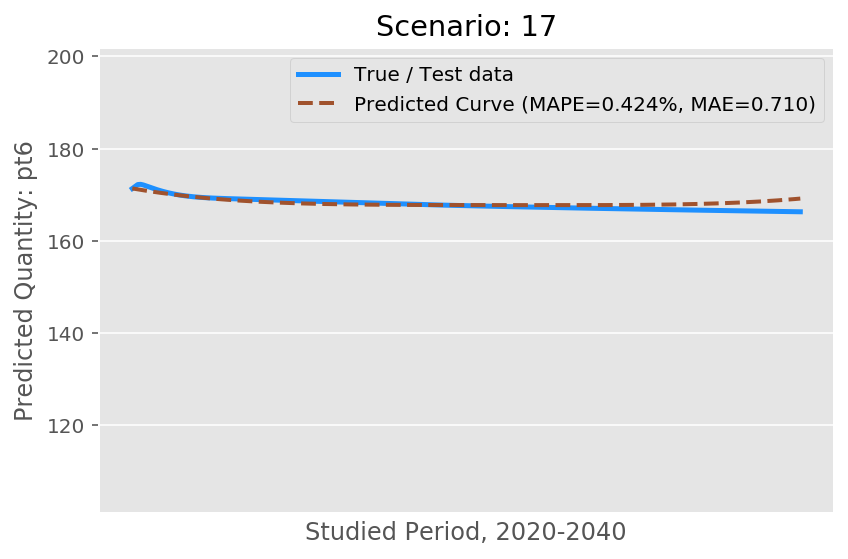

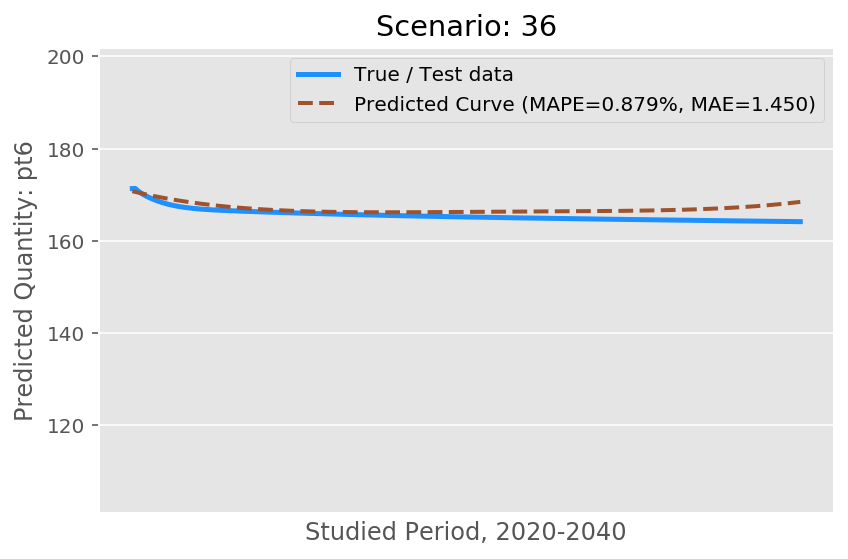

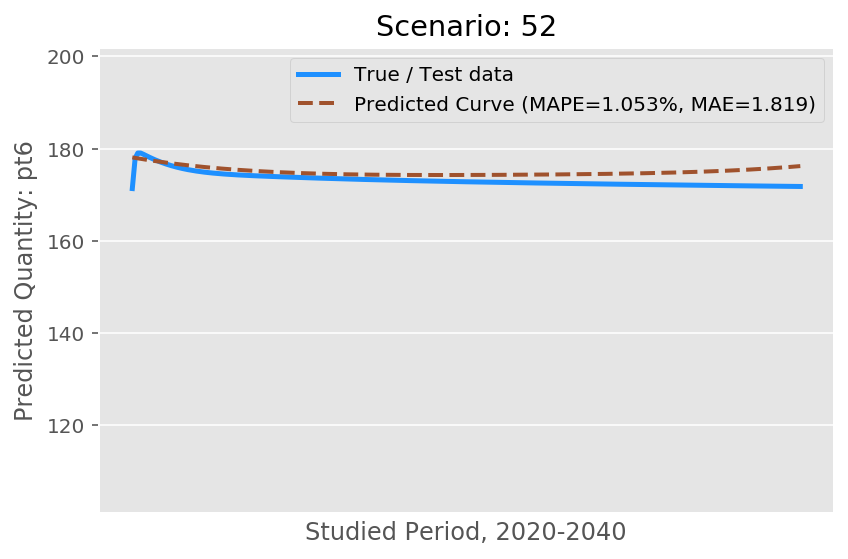

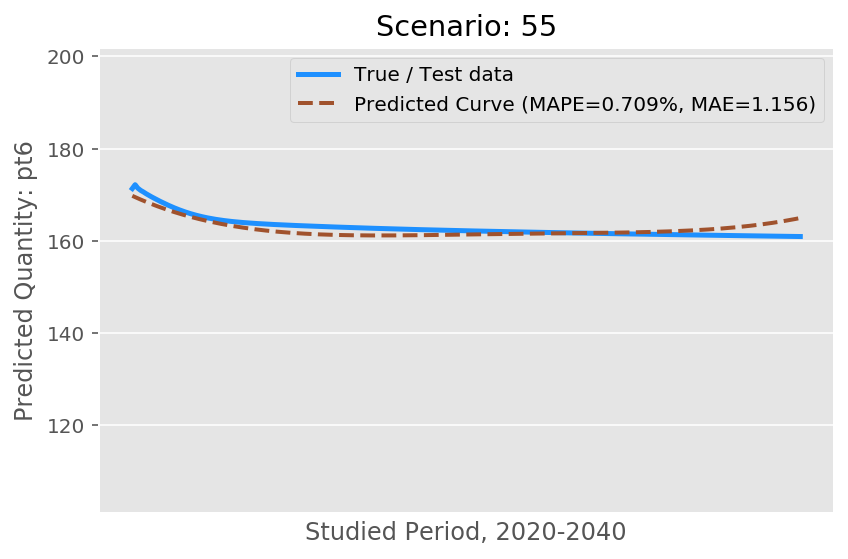

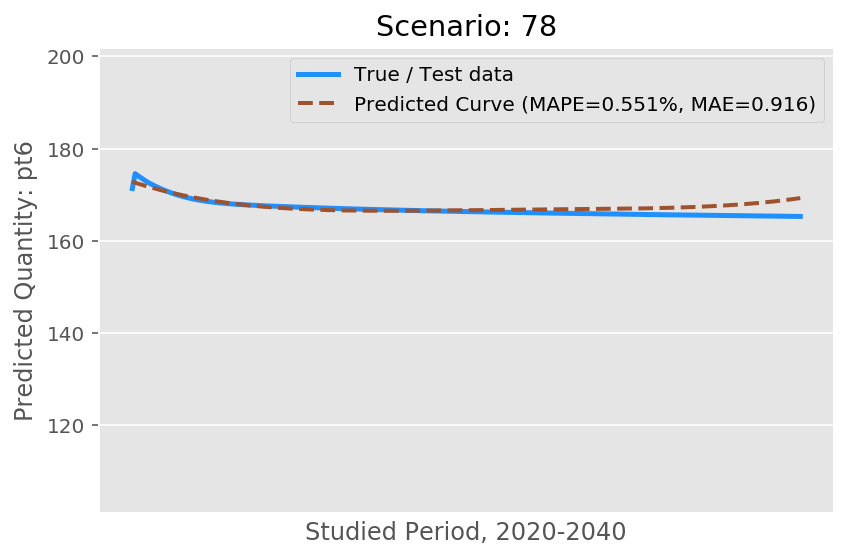

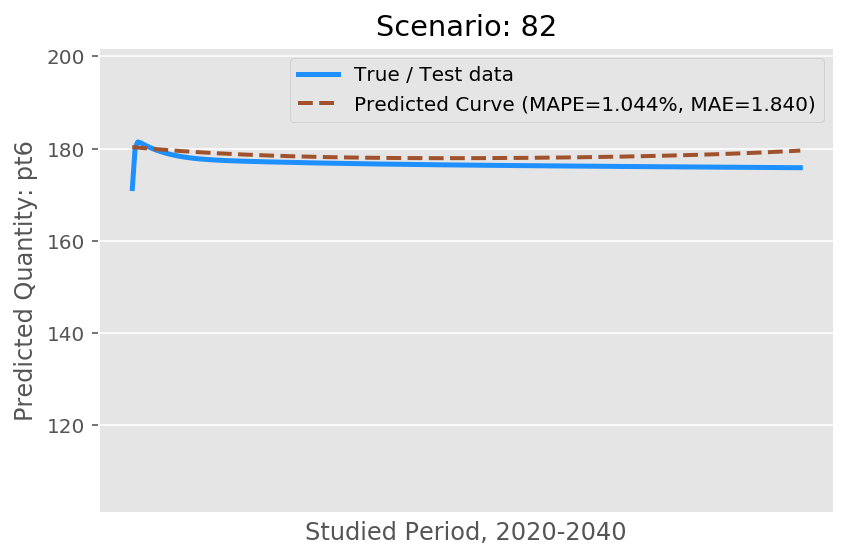

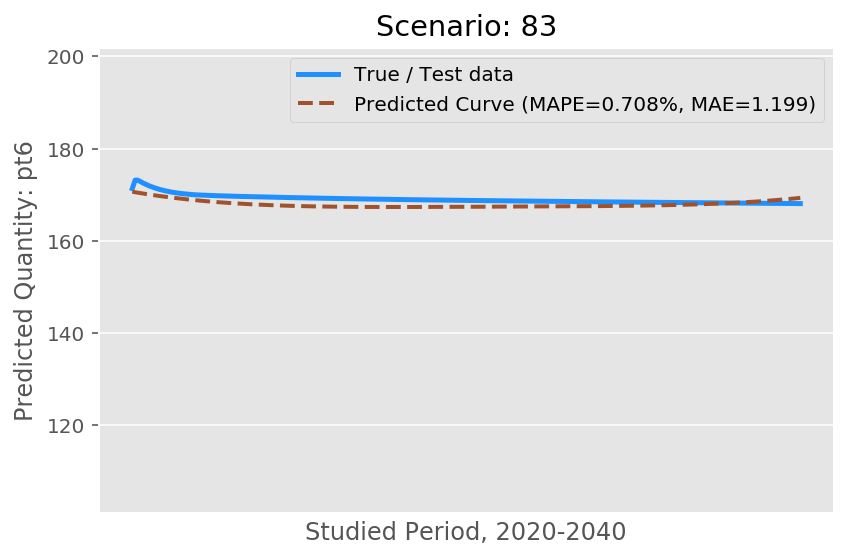

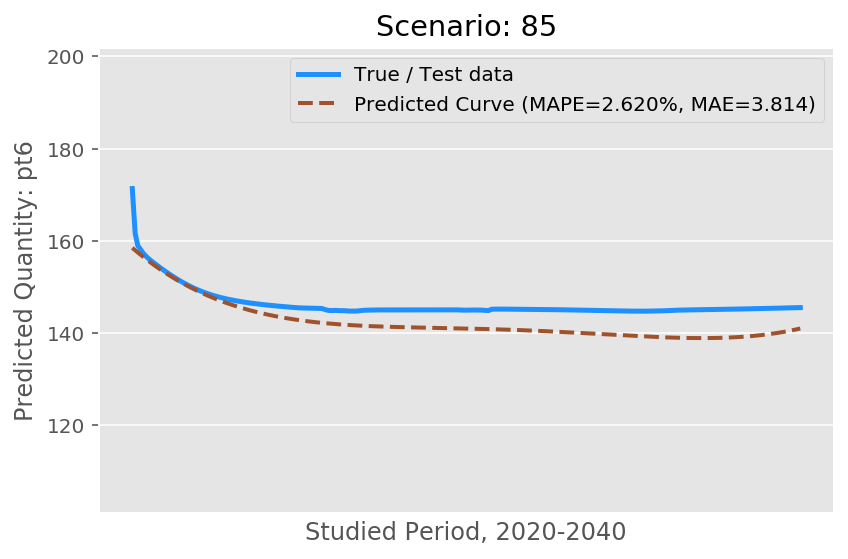

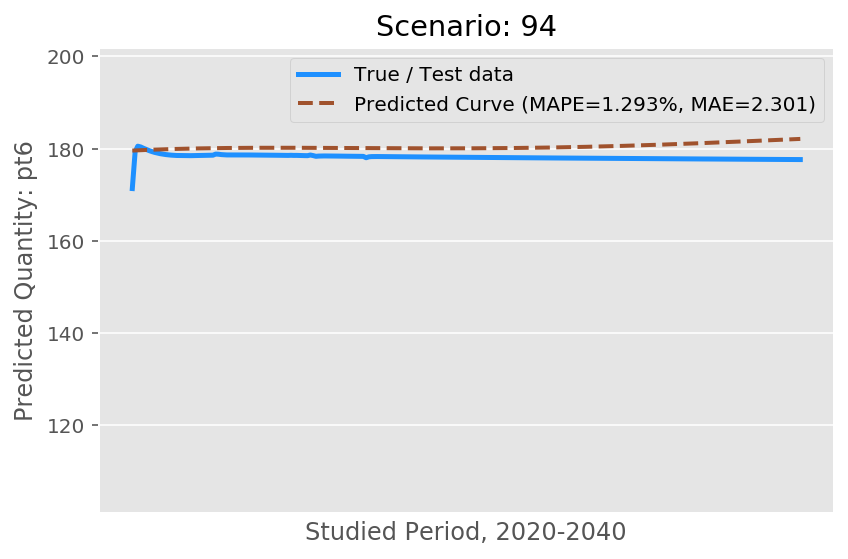

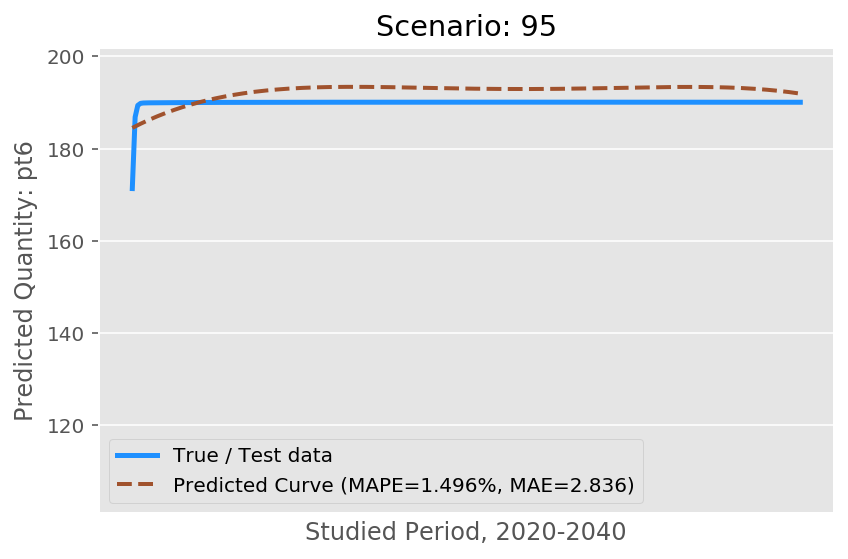

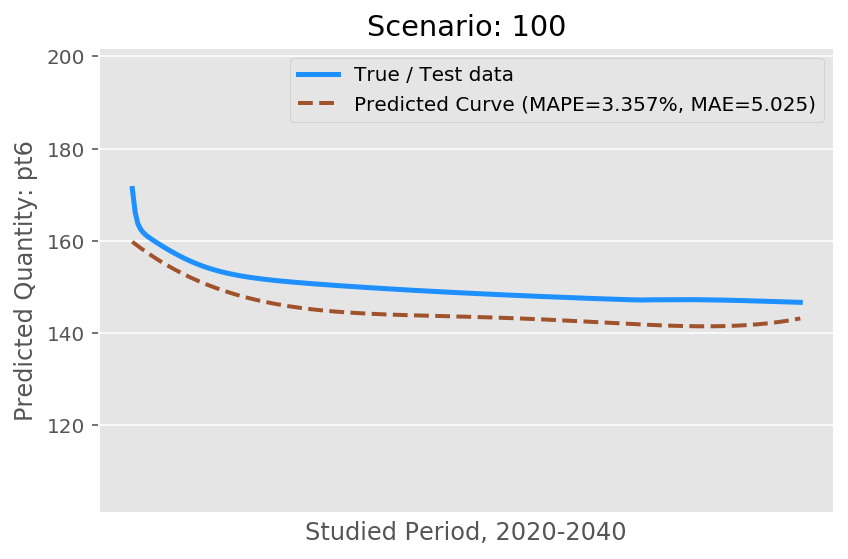

In [7]:
plotting = True
degree = 4
required_results_df_columns = ["timestamp", "train_idx", "quantity", "degree", "mape_list", "mae_list", "mape_avg", "mae_avg"]                        

# This predicted ensemble object will be populated with predicted timeseries values, scaled and unscaled
ens_predicted = ReservoirPredictionEnsemble(config, cases_list_for_prediction)  

# Form a dataframe with all controlled parameter values
m_column_list = ["im1", "im2", "im3", "im4"]
injector_df = pd.DataFrame(index=range(ens.count), columns=m_column_list)
for i in range(ens.count):
    df = ens[i].scaled_timeseries[m_column_list]
    df = df[df.index >= pd.to_datetime('2020-01-01')]

    for c in m_column_list:
        # Important: this characterizes a timeseries by its most common values; different methods can be used here
        # This works well for the step function
        injector_df.at[i, c] = df[c].value_counts().index[0]

m_column_list = ["pm1", "pm2", "pm3", "pm4", "pm5", "pm6"]
producer_df = pd.DataFrame(index=range(ens.count), columns=m_column_list)
for i in range(ens.count):
    df = ens[i].scaled_timeseries[m_column_list]
    df = df[df.index >= pd.to_datetime('2020-01-01')]

    for c in m_column_list:
        # Important: this characterizes a timeseries by its most common values; different methods can be used here
        # This works well for the step function
        producer_df.at[i, c] = df[c].value_counts().index[0]

all_wells_df = injector_df.join(producer_df)
display(all_wells_df)

poly = get_polynomial_func(degree=degree)

results_df = pd.DataFrame(columns = required_results_df_columns)

for quantity in quantity_list:
    print("Quantity:", quantity)

    if quantity in ["pp1", "pp2", "pp3", "pp4", "pp5", "pp6"]:
        scaler = ens.common_pres_scaler
    elif quantity in ["pt1", "pt2", "pt3", "pt4", "pt5", "pt6"]:
        scaler = ens.common_temp_scaler

    t_mapper = ens.shared_scaled_time_index(start_at='2020-01-01')
    #t_mapper = {k: v+1.0 for k,v in t_mapper.items()}

    ydata_df = pd.DataFrame(index=sorted(t_mapper.values()), columns=range(ens.count))
    yhat_df = pd.DataFrame(index=sorted(t_mapper.values()), columns=range(ens.count))

    coeff_df, _, quantity_min_max = ens.get_curve_approximations(quantity, poly)

    #display(coeff_df)

    #print("Input for Curve ML training:")
    X_train = all_wells_df.loc[train_idx]
    #display(X_train)

    #print("Output for Curve ML training:")
    Y_train = coeff_df.loc[train_idx]
    #display(Y_train)

    X_test = all_wells_df.loc[test_idx]
    Y_test = coeff_df.loc[test_idx]

    model = trained_models_dict[quantity]
    
    X_test=np.asarray(X_test).astype(np.float32)
    Y_test=np.asarray(Y_test).astype(np.float32)

    # Predicted coefficients
    Y_test_pred = model.predict(X_test, verbose=0)

    xdata = np.linspace(0, 1.0, 50) # point along scaled time dimension

    mape_list, mae_list = [], []
    for coeff_true, coeff_pred, test_case_id in zip(Y_test, Y_test_pred, test_idx):
        one_traj = ens[test_case_id].scaled_timeseries[quantity]
        one_traj = one_traj[one_traj.index >= pd.to_datetime('2020-01-01')]
        xdata_for_true_data = np.array(one_traj.index.map(t_mapper))
        ydata_not_fitted = one_traj.values

        ydata_true = poly(xdata, *coeff_true)
        ydata_pred = poly(xdata, *coeff_pred)
        ydata_pred_for_error_est = poly(xdata_for_true_data, *coeff_pred)

        # Perform error analysis on unscaled data
        ydata_not_fitted_unscaled = scaler.inverse_transform(ydata_not_fitted.reshape(-1, 1)).reshape(-1,)
        ydata_pred_for_error_est_unscaled = scaler.inverse_transform(ydata_pred_for_error_est.reshape(-1, 1)).reshape(-1,)
        mape = mean_absolute_percentage_error(ydata_not_fitted_unscaled, ydata_pred_for_error_est_unscaled)
        mae = mean_absolute_error(ydata_not_fitted_unscaled, ydata_pred_for_error_est_unscaled)

        mape_list.append(mape)
        mae_list.append(mae)
        
        if plotting:
            plt.plot(xdata_for_true_data, 
                 ydata_not_fitted_unscaled, 
                 '-', c="dodgerblue", label="True / Test data", linewidth=2.5)
            plt.plot(xdata_for_true_data, 
                 ydata_pred_for_error_est_unscaled, 
                 '--', c="sienna", label="Predicted Curve (MAPE=%.3f%%, MAE=%.3f)" % (mape, mae), linewidth=2.0)

            quantity_min_max_row = quantity_min_max[quantity_min_max["quantity"] == quantity]
            if len(quantity_min_max_row) == 1:
                qmin = quantity_min_max_row["quantity_min"].values[0]
                qmax = quantity_min_max_row["quantity_max"].values[0]
                qrange = qmax - qmin
                plt.ylim([qmin-qrange*0.15, qmax+qrange*0.15])
            plt.legend()
            #plt.title("Quantity: %s, Scenario: %s" % (quantity, test_case_id))
            plt.title("Scenario: %s" % (test_case_id))

            ax = plt.gca()
            ax.axes.xaxis.set_ticks([])
            ax.set_xlabel("Studied Period, 2020-2040")
            ax.set_ylabel("Predicted Quantity: %s" % quantity)
            plt.tight_layout()
            plt.show()

        #ens_predicted[test_case_id].scaled_timeseries[quantity] = ydata_pred_for_error_est
        ens_predicted[test_case_id].timeseries[quantity] = ydata_pred_for_error_est_unscaled

    now = datetime.now()
    results_df.loc[len(results_df)] = [
        now, 
        train_idx,
        quantity, degree,
        mape_list, mae_list, np.array(mape_list).mean(), np.array(mae_list).mean()]

In [8]:
# Results of the error analysis can be found in this dataframe and used for furhter analysis & plotting
display(results_df)

timestamp  \
0  2022-01-21 13:23:01.722347   
1  2022-01-21 13:23:03.786698   
2  2022-01-21 13:23:06.019164   
3  2022-01-21 13:23:08.236502   
4  2022-01-21 13:23:10.294388   
5  2022-01-21 13:23:12.511350   
6  2022-01-21 13:23:14.746344   
7  2022-01-21 13:23:16.958020   
8  2022-01-21 13:23:19.092987   
9  2022-01-21 13:23:21.304171   
10 2022-01-21 13:23:23.578712   
11 2022-01-21 13:23:25.610483   

                                            train_idx quantity degree  \
0   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pp1      4   
1   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pp2      4   
2   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pp3      4   
3   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pp4      4   
4   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pp5      4   
5   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pp6      4   
6   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pt1      4   
7   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pt2      4   
8   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pt3      4   
9   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pt4      4   
10  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pt5      4   
11  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      pt6      4   

                                            mape_list  \
0   [1.0780024686978238, 0.9471714314538667, 1.037...   
1   [0.8540663674899314, 0.665434780968435, 0.2244...   
2   [0.5182469600192994, 0.29278337285209555, 0.16...   
3   [1.6182224428759102, 1.2365833200150642, 1.365...   
4   [0.43026008069525473, 0.3570625693962313, 0.60...   
5   [0.26413781808140085, 0.1252092142462285, 0.01...   
6   [1.8253131451831919, 1.190848562476452, 1.6039...   
7   [0.3453131585753328, 0.45997092553828917, 0.31...   
8   [0.6792906417562634, 0.6994531168500475, 0.120...   
9   [0.27723170261533386, 0.9002842977959407, 1.12...   
10  [0.5917797311549183, 1.054351574259544, 0.8046...   
11  [0.4243188609805078, 0.8787566455569649, 1.053...   

                                             mae_list  mape_avg     mae_avg  
0   [222.96339518793684, 194.42480628517083, 217.2...  0.974663  202.340738  
1   [97.28846756157049, 76.41083928738429, 26.5208...  0.709541   77.072026  
2   [66.14124830922215, 37.64727891760374, 21.6058...  0.382767   48.559835  
3   [183.83681663803193, 141.76271262259593, 160.7...  1.179496  135.371209  
4   [98.13173719134645, 80.90915450997973, 139.033...  0.468877  109.276655  
5   [60.223762518690485, 28.360694421042844, 2.530...  0.278076   64.003580  
6   [2.0244560796911384, 1.256233001261059, 1.7455...  2.041603    2.212226  
7   [0.3136044671079958, 0.38958250484271256, 0.26...  0.557670    0.536177  
8   [0.7384833216592328, 0.7231029344996118, 0.119...  1.133955    1.312944  
9   [0.3678821472670731, 1.1062320539534536, 1.360...  1.373802    1.638556  
10  [0.7437995840116294, 1.2664746451915911, 1.029...  1.506489    1.838537  
11  [0.7098316729935946, 1.4499789618121872, 1.818...  1.284896    2.096880